# Final Project Jupyter Notebook #

**Data contained in this notebook comes from Dr. Kaoru Ikuma. This data contains water quality parameters sampled at locations along the Des Moines and Raccoon Rivers. At the completion of this notebook, data will be organized into one dataframe (named master), helpful visuals will be generated, data imputation will be demonstrated, and multiple machine learning models will be created. In this version, I have made sure to remove my API Token. File Paths will need to be updated per user machine. If errors are encountered, imported packages may need to be updated.**

Our first order of business is importing all the necessary python libraries to do our analyses!

In [106]:
import pandas as pd
import requests
import glob
import datetime
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns; sns.set()
%matplotlib inline

Let's see how where these sampling sites our located! To do this we will read an Excel file containing this information in our DWRWQN data folder.

*The final parts of this file path should be '...516project/DWRWQN data/Spreadsheets/Site_LatLong.xlsx'*

In [107]:
locations = pd.read_excel('U:/516project/DWRWQN data/Spreadsheets/Site_LatLong.xlsx')
fig = px.scatter_mapbox(locations,lat='Latitude (N)',lon='Longitude (W)', hover_name="Site")
fig.update_layout(title = 'World map', title_x=0.5)
fig.update_layout(mapbox_style = "open-street-map")
fig.show()

## Data Wrangling ##
Our data is currently stored in seperate Excel files in our DWRWQN Data folder. We need to bring all of our information into a singluar workspace that makes it easier to do analysis. We will start by converting all of these Excel files into dataframes and then storing them in a list.

*The final parts of this file path should be '...516project/DWRWQN data/Spreadsheets/Important Files/*.xlsx'*

In [14]:
file_list = glob.glob ('U:/516project/DWRWQN data/Spreadsheets/Important Files/*.xlsx')
test=file_list[0:5]

df_list=list()

for files in file_list:
    temp_df= pd.read_excel(files)
    temp_df = temp_df.iloc[:,0:5]
    #filename = str(files)
    df_list.append(temp_df)


Now that we have our dataframes are stored in a list, let's get a list of what parameters we have. We will do this by by slicing them from the Excel filenames. Depending on the file directory, our index changes, so I have included a test print to see if we accurately capture the filename before continuing on with our parameter name list.

In [15]:
#Test to see what index is needed to splice the parameter name from the filenames
filename= str(test[0])
print(filename[59:-5])

#Let's create a list of parameter names from the filenames in the folder to use later for column headings
name_list=list()

for files in file_list:
    filename = str(files)
    name_list.append(filename[59:-5])
print(name_list) 

Flowrate
['Flowrate', 'Temperature', 'Turbidity', 'TotalSolids', 'SuspendedSolids', 'pH', 'TotalOrganicCarbon', 'TotalCarbon', 'BiochemicalOxygenDemand', 'DissolvedOxygen', 'Nitrite+NitrateNitrogen', 'TotalNitrogen', 'TotalColiformBacteria', 'FecalColiformBacteria', 'TotalPhosphate', 'OrthoPhosphate', 'Chloride', 'NitrateNitrogen', 'Chlorophylla', 'TotalSolublePhosphorus', 'CorrectedChlorophylla', 'DOC', 'Microcystin_LR']


Currently, the parameters are characterized by a "Parameter Number" that is defined in yet another spreadsheet. Let's rename the individual dataframe columns with the actual names of the parameters here so when we eventually combine it is easier to read.

In [16]:
index = 0
while index < len(name_list):
    print(name_list[index])
    
    #Rename Columns to Parameter Names
    df_list[index]= df_list[index].rename(columns={'Value': name_list[index]})
    df_list[index]= df_list[index].rename(columns={'Parameter Number': 'Parameter'})
    
    #Drop the Parameter Column, I don't need it in my master dataframe because my value column is labeled
    df_list[index] = df_list[index].drop(['Parameter'], axis = 1)
    
    print(df_list[index].head())
    index = index+1

Flowrate
  Site       Date Sign  Flowrate
0    0 1975-09-11  NaN       250
1    0 1975-11-06  NaN       460
2    0 1976-01-13  NaN       134
3    0 1976-03-17  NaN      2350
4    0 1976-05-12  NaN      1050
Temperature
  Site       Date Sign  Temperature
0    0 1975-11-06  NaN         16.5
1    0 1976-01-13  NaN          1.0
2    0 1976-03-17  NaN          2.5
3    0 1976-05-12  NaN         18.0
4    0 1977-01-25  NaN          0.0
Turbidity
  Site       Date Sign  Turbidity
0    0 1984-05-08  NaN       60.0
1    0 1984-05-15  NaN       35.0
2    0 1984-05-21  NaN       40.0
3    0 1984-06-18  NaN      270.0
4    0 1984-06-25  NaN      100.0
TotalSolids
  Site       Date  Sign  TotalSolids
0    1 1967-07-13   NaN          655
1    1 1967-07-20   NaN          633
2    1 1967-07-27   NaN          658
3    1 1967-08-03   NaN          626
4    1 1967-08-10   NaN          649
SuspendedSolids
  Site       Date Sign  SuspendedSolids
0    0 1984-05-08  NaN             91.0
1    0 1984-05-15  Na

Now that we have that covered up. It is time to combine all the information stored in our Excel file. To do this, we will need to make sure our keys are all formatted the same way. Let's convert our Date column to a date_time datatype.

In [17]:
#Convert Date to DateTime
for data in df_list:
    data['Date']= pd.to_datetime(data['Date'])

The first merge is the most important, because it will dictate the size of our entire dataframe. Let's make sure we choose the largest dataframe as our left_key

In [18]:
for df in df_list:
    print(df.columns[3])
    print(len(df))

Flowrate
8733
Temperature
16435
Turbidity
15347
TotalSolids
4952
SuspendedSolids
10644
pH
15520
TotalOrganicCarbon
8051
TotalCarbon
4793
BiochemicalOxygenDemand
10444
DissolvedOxygen
15887
Nitrite+NitrateNitrogen
12667
TotalNitrogen
9024
TotalColiformBacteria
2878
FecalColiformBacteria
12736
TotalPhosphate
9412
OrthoPhosphate
10409
Chloride
3540
NitrateNitrogen
2263
Chlorophylla
8593
TotalSolublePhosphorus
1484
CorrectedChlorophylla
6162
DOC
9
Microcystin_LR
221


Now we know that we have the most data for temperature, let's make that our leftmost dataframe so that it dictates the size of our dataframe. We want to catch the most data possible!

In [19]:
#Initialize Master Dataframe
master = pd.merge(df_list[1], df_list[0], on = ['Date','Site'], how= "left", suffixes = [2,3])

#Create a list to join from
df_joinlist= df_list.copy()
del df_joinlist[0:2]


#When I use the whole file list, an empty dataframe is returned
test = df_joinlist[0:3]

#Count is used so that replicate headings can be matched with parameter values. Every dataframe has a sign column, so we need
#to rename as we merge
count= 3
for df in df_joinlist:
    master= pd.merge(master, df, on =['Date', 'Site'], how = "left", suffixes= [count, count+1])
    count= count+1

## API Calls ##
*How can we enhance our data with what is freely available?*

For this section, I am going to utilize NOAA's API. In order to use this API you will need to sign up for a token. Use the link below to sign up for a token using your email.

https://www.ncdc.noaa.gov/cdo-web/token

In preparation for our API Call. We are goig to need to create a datset with location and date data for all our samples from our master dataframe.

In [20]:
sample_times = master[['Site','Date']].copy()
samples = pd.merge(sample_times, locations, on = 'Site', how="inner")
samples.drop(['Site Name'], axis = 1, inplace = True)
samples.head()

,Site,Date,Latitude (N),Longitude (W),Zipcodes
0,0,1975-11-06,42.252392,-93.996,50249
1,0,1976-01-13,42.252392,-93.996,50249
2,0,1976-03-17,42.252392,-93.996,50249
3,0,1976-05-12,42.252392,-93.996,50249
4,0,1977-01-25,42.252392,-93.996,50249


I am going to find the unique zipcodes in the dataset, and check them one by one in the dataset below. Feel free to do the same by changing the test_zipcode variable. A zipcode with no data in the NOAA database will return an empty dictionary.

In [21]:
#Choose zipcodes from the array output
samples.Zipcodes.unique()

array([50249, 50036, 50003, 50276, 50226, 50131, 50313, 50327, 50252,
       50219, 50214, 50119, 50138, 50062], dtype=int64)

In [22]:
test_zipcode = 50036

my_headers = {'token': 'your_token_here'}

start = "2010-05-01"
end = start

params = {
    "datasetid": "GHCND",
    "locationid": "ZIP:"+str(test_zipcode),
    "datatypeid": ["PRCP","TMAX","TMIN"],
    "units": "standard",
    "startdate": start,
    "enddate": end,
    "includemetadata": "false",
}

url = "https://www.ncei.noaa.gov/cdo-web/api/v2/data"
resp = requests.get(url, params=params, headers= my_headers)
print(resp.json())

{'results': [{'date': '2010-05-01T00:00:00', 'datatype': 'PRCP', 'station': 'GHCND:US1IABN0005', 'attributes': ',,N,0700', 'value': 0.1}, {'date': '2010-05-01T00:00:00', 'datatype': 'PRCP', 'station': 'GHCND:USC00130200', 'attributes': ',,0,1600', 'value': 0.0}, {'date': '2010-05-01T00:00:00', 'datatype': 'TMAX', 'station': 'GHCND:USC00130200', 'attributes': ',,0,1600', 'value': 68.0}, {'date': '2010-05-01T00:00:00', 'datatype': 'TMIN', 'station': 'GHCND:USC00130200', 'attributes': ',,0,1600', 'value': 45.0}, {'date': '2010-05-01T00:00:00', 'datatype': 'PRCP', 'station': 'GHCND:USC00130807', 'attributes': ',,0,0800', 'value': 0.13}, {'date': '2010-05-01T00:00:00', 'datatype': 'TMAX', 'station': 'GHCND:USC00130807', 'attributes': ',,0,0800', 'value': 68.0}, {'date': '2010-05-01T00:00:00', 'datatype': 'TMIN', 'station': 'GHCND:USC00130807', 'attributes': ',,0,0800', 'value': 44.0}]}


*If the above code yields "{'status': '429', 'message': 'This token has reached its temporary request limit of 10000 per day.'}" you will have to wait 24 hours to run this API Calls section. If needed, you can load the data from this API call that is stored in the 'noaa.xlsx' file in the directory.*

We will want to create a looping function to iterate over our different sampling zipcodes and times to grab weather data. Let's first see if we can create a loop to make a dataframe row. Make sure the above code returned a database entry before running the below code!

In [23]:
dct = resp.json()
test= pd.DataFrame(columns=['Zipcode','Date','PRCP','TMAX','TMIN'])

temp_list= list()
name_list = list()

if len(dct)==0:
    print('error')
else:
    resultlist= dct['results']
    for d in resultlist:
        if d['datatype'] in name_list: #Boolean check to make sure I am not putting in duplicate measurements.
            continue
        else:
            name_list.append(d['datatype'])
            temp_list.append(d['value'])
            #print (d['datatype'])
            #print(d['value'])
test.loc[0] = ["50313","May 5",temp_list[0],temp_list[1],temp_list[2]]
#test ##Take away comment for visual

Now that we have done it for one zipcode, let's iterate for our entire dataset! Running this cell will take quite some time. (~2 hours).

In [24]:
my_headers = {'token': 'your_token_here'}

noaa= pd.DataFrame(columns=['Zipcode','Date','PRCP','TMAX','TMIN']) #Instantiate an empty dataframe with columns for each datatype

count = 0

for zipcode in samples['Zipcodes']:
    
    #Define the parameters for the API Call: Date, Dataset, Location, and Datatype
    date = str(samples.loc[count]['Date']) #Pull the date from the samples_df 'Date' column
    start = date[:10]
    end = start
    params = {
        "datasetid": "GHCND",
        "locationid": "ZIP:"+str(zipcode), #Each API Call is using the zipcode in the dataframe
        "datatypeid": ["PRCP","TMAX","TMIN"],
        "units": "standard",
        "startdate": start,
        "enddate": end,
        "includemetadata": "false",
    }

    url = "https://www.ncei.noaa.gov/cdo-web/api/v2/data"
    resp = requests.get(url, params=params, headers= my_headers)
    try:#Needed to implement this in order to prevent loop from breaking when JSON would throw a server error code at me
        dct = resp.json()
        count = count+1
        if len(dct) ==0:#If there is no data for this date and location, break loop and move to next API call
            continue
        else:
            resultlist=dct['results']
            temp_list=list()
            name_list=list()
            
        for d in resultlist:
            if d['datatype'] in name_list: #Make sure there are no duplicate measurements from multiple stations in same zipcode
                continue
            else:
                temp_list.append(d['value'])
                name_list.append(d['datatype'])
        
        noaa.loc[count]=[str(zipcode),str(start),temp_list[0],temp_list[1],temp_list[2]]#Insert row with data from API Call
    except:
        continue
noaa

,Zipcode,Date,PRCP,TMAX,TMIN
36,50036,1967-07-06,0.00,77.0,49.0
37,50036,1967-07-13,0.00,80.0,52.0
38,50036,1967-07-20,0.01,86.0,64.0
39,50036,1967-07-27,0.12,76.0,63.0
40,50036,1967-08-03,0.18,82.0,60.0
...,...,...,...,...,...
7909,50313,2012-03-26,0.00,79.0,48.0
7910,50313,2012-04-02,0.00,89.0,48.0
7911,50313,2012-04-23,0.00,58.0,39.0
7915,50313,2012-06-18,0.00,90.0,60.0


In [105]:
noaa.to_excel('noaa_output.xlsx') #Save output to an excel file so that I don't have to run the API call everytime

### When you need to run code but can't wait for the API Call, switch this line to code and load this excel file ###

noaa = pd.read_excel('U:/516project/noaa_output.xlsx')

noaa= noaa.drop(noaa.columns[0], axis = 1)

In [25]:
noaa.dtypes

Zipcode     object
Date        object
PRCP       float64
TMAX       float64
TMIN       float64
dtype: object

In [26]:
noaa['Zipcode']= noaa['Zipcode'].astype(str).astype(float).astype(int) #Make sure both dataframes have zipcodes of the same datatype
noaa['Date'] = pd.to_datetime(noaa['Date']) #Make sure both dataframes have dates stored as the same datatype

Let's merge our API dataframe (noaa) with our sample dataframe (samples)

In [27]:
weather_obs= pd.merge(samples, noaa, left_on = ['Zipcodes', 'Date'], right_on= ["Zipcode",'Date'], how="left")
weather_obs

,Site,Date,Latitude (N),Longitude (W),Zipcodes,Zipcode,PRCP,TMAX,TMIN
0,0,1975-11-06,42.252392,-93.996000,50249,NaN,NaN,NaN,NaN
1,0,1976-01-13,42.252392,-93.996000,50249,NaN,NaN,NaN,NaN
2,0,1976-03-17,42.252392,-93.996000,50249,NaN,NaN,NaN,NaN
3,0,1976-05-12,42.252392,-93.996000,50249,NaN,NaN,NaN,NaN
4,0,1977-01-25,42.252392,-93.996000,50249,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
18067,WES-R-WBC-9,1979-05-14,41.374059,-93.098993,50138,NaN,NaN,NaN,NaN
18068,WES-R-WBC-9,1979-05-21,41.374059,-93.098993,50138,NaN,NaN,NaN,NaN
18069,WES-R-WBC-9,1979-05-28,41.374059,-93.098993,50138,NaN,NaN,NaN,NaN
18070,WES-R-WBC-9,1979-06-04,41.374059,-93.098993,50138,NaN,NaN,NaN,NaN


There are a lot of NaN values, but that is because NOAA does not have a weather station in every zipcode for our samples. We are also limited to 10,000 calls per day on our API, so we do not make it through the whole dataframe. If we wanted to fully fill out the dataframe as much as possible, we could run back to back API calls with a new token at a new email, but I chose to stick with just one token for now.

To prep the weather_obs dataframe to merge with our master dataframe, we are going to drop the unncecessary location and zipcode columns.

In [28]:
weather_obs = weather_obs.drop(weather_obs.columns[[2,3,4,5]], axis=1)
weather_obs.head()

,Site,Date,PRCP,TMAX,TMIN
0,0,1975-11-06,NaN,NaN,NaN
1,0,1976-01-13,NaN,NaN,NaN
2,0,1976-03-17,NaN,NaN,NaN
3,0,1976-05-12,NaN,NaN,NaN
4,0,1977-01-25,NaN,NaN,NaN


In [29]:
master = pd.merge(master,weather_obs, left_on=['Site', 'Date'], right_on=['Site', 'Date'], how= "left")
master

,Site,Date,Sign2,Temperature,Sign3,Flowrate,Sign4,Turbidity,Sign5,TotalSolids,...,TotalSolublePhosphorus,Sign22,CorrectedChlorophylla,Sign23,DOC,Sign,Microcystin_LR,PRCP,TMAX,TMIN
0,0,1975-11-06,NaN,16.5,NaN,460.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,1976-01-13,NaN,1.0,NaN,134.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,1976-03-17,NaN,2.5,NaN,2350.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,1976-05-12,NaN,18.0,NaN,1050.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1977-01-25,NaN,0.0,NaN,14.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18164,WES-WBC-I,1979-08-27,NaN,23.0,NaN,NaN,NaN,44.0,NaN,418.0,...,0.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18165,WES-WBC-I,1979-09-04,NaN,31.5,NaN,NaN,NaN,23.0,NaN,452.0,...,0.41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18166,WES-WBC-I,1979-09-10,NaN,29.0,NaN,NaN,NaN,22.0,NaN,452.0,...,0.31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18167,WES-WBC-I,1979-09-17,NaN,25.0,NaN,NaN,NaN,23.0,NaN,489.0,...,0.48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Visualizing the Data ##
*How much data do we have? Where is it located?*

Let's get an idea of how sparse our dataset is by printing the amount of NaN values we have in each column. Then, let's create a list of our site_numbers to use later in a for loop

In [30]:
print(master.isna().sum())
site_numbers = list(set(master.Site.values.tolist()))

Site                           0
Date                           0
Sign2                      18063
Temperature                    0
Sign3                      18141
Flowrate                   10361
Sign4                      18107
Turbidity                   2428
Sign5                      18169
TotalSolids                13424
Sign6                      18080
SuspendedSolids             7361
Sign7                      18102
pH                          1187
Sign8                      18147
TotalOrganicCarbon         10246
Sign9                      18169
TotalCarbon                13557
Sign10                     18051
BiochemicalOxygenDemand     7880
Sign11                     18103
DissolvedOxygen              832
Sign12                     18052
Nitrite+NitrateNitrogen     4996
Sign13                     18156
TotalNitrogen               8963
Sign14                     18106
TotalColiformBacteria      15396
Sign15                     17723
FecalColiformBacteria       8724
Sign16    

Now, we want a good way to visualize how many tests of each parameter we have at each site location. This is going to use nested for loops. Let's test out the first part of our for loop below

In [31]:
#Let's test out the parameter part of our for loop before we nest it in a for loop iterating on site numbers!
parameters= list(master.columns)
temp_list=list()
count_df = pd.DataFrame(columns = parameters)

for paramater in parameters:
    paramater_count = master[master["Site"] == 0].count()[paramater]
    temp_list.append(paramater_count)

count_df.loc[len(count_df.index)] = temp_list
#count_df ##Remove this comment if you want to see proof

It works! Let's nest it into another for loop that moves along our site_numbers list.

In [32]:
count_df = pd.DataFrame(parameters).T #Initialize an empty frame to store count values
temp_list= list() #Initialize an empty list to temporarily store count values before inserting it into the frame

for site in site_numbers:
    for parameter in parameters:
        parameter_count = master[master["Site"] == site].count()[parameter]
        temp_list.append(parameter_count)
        
    count_df.loc[len(count_df.index)] = temp_list
    temp_list= list()
    
#count_df.head() ##Remove comment for visual

Somehow our [0] index is what we want to be our column headings. Let's fix that and include a column with our site numbers so which places to attribute the counts

In [33]:
count_df.columns = count_df.iloc[0]

count_df = count_df.drop([0])
count_df = count_df.reset_index(drop = True)
new_col = pd.Series(site_numbers)
count_df['Site Numbers'] = new_col.values
moving_column = count_df.pop("Site Numbers")
count_df.insert(0, "Site Numbers", moving_column)
#count_df.head() ##Remove comment for visual

Let's create a stacked bar graph so we can see how much of each parameter we have for each site!

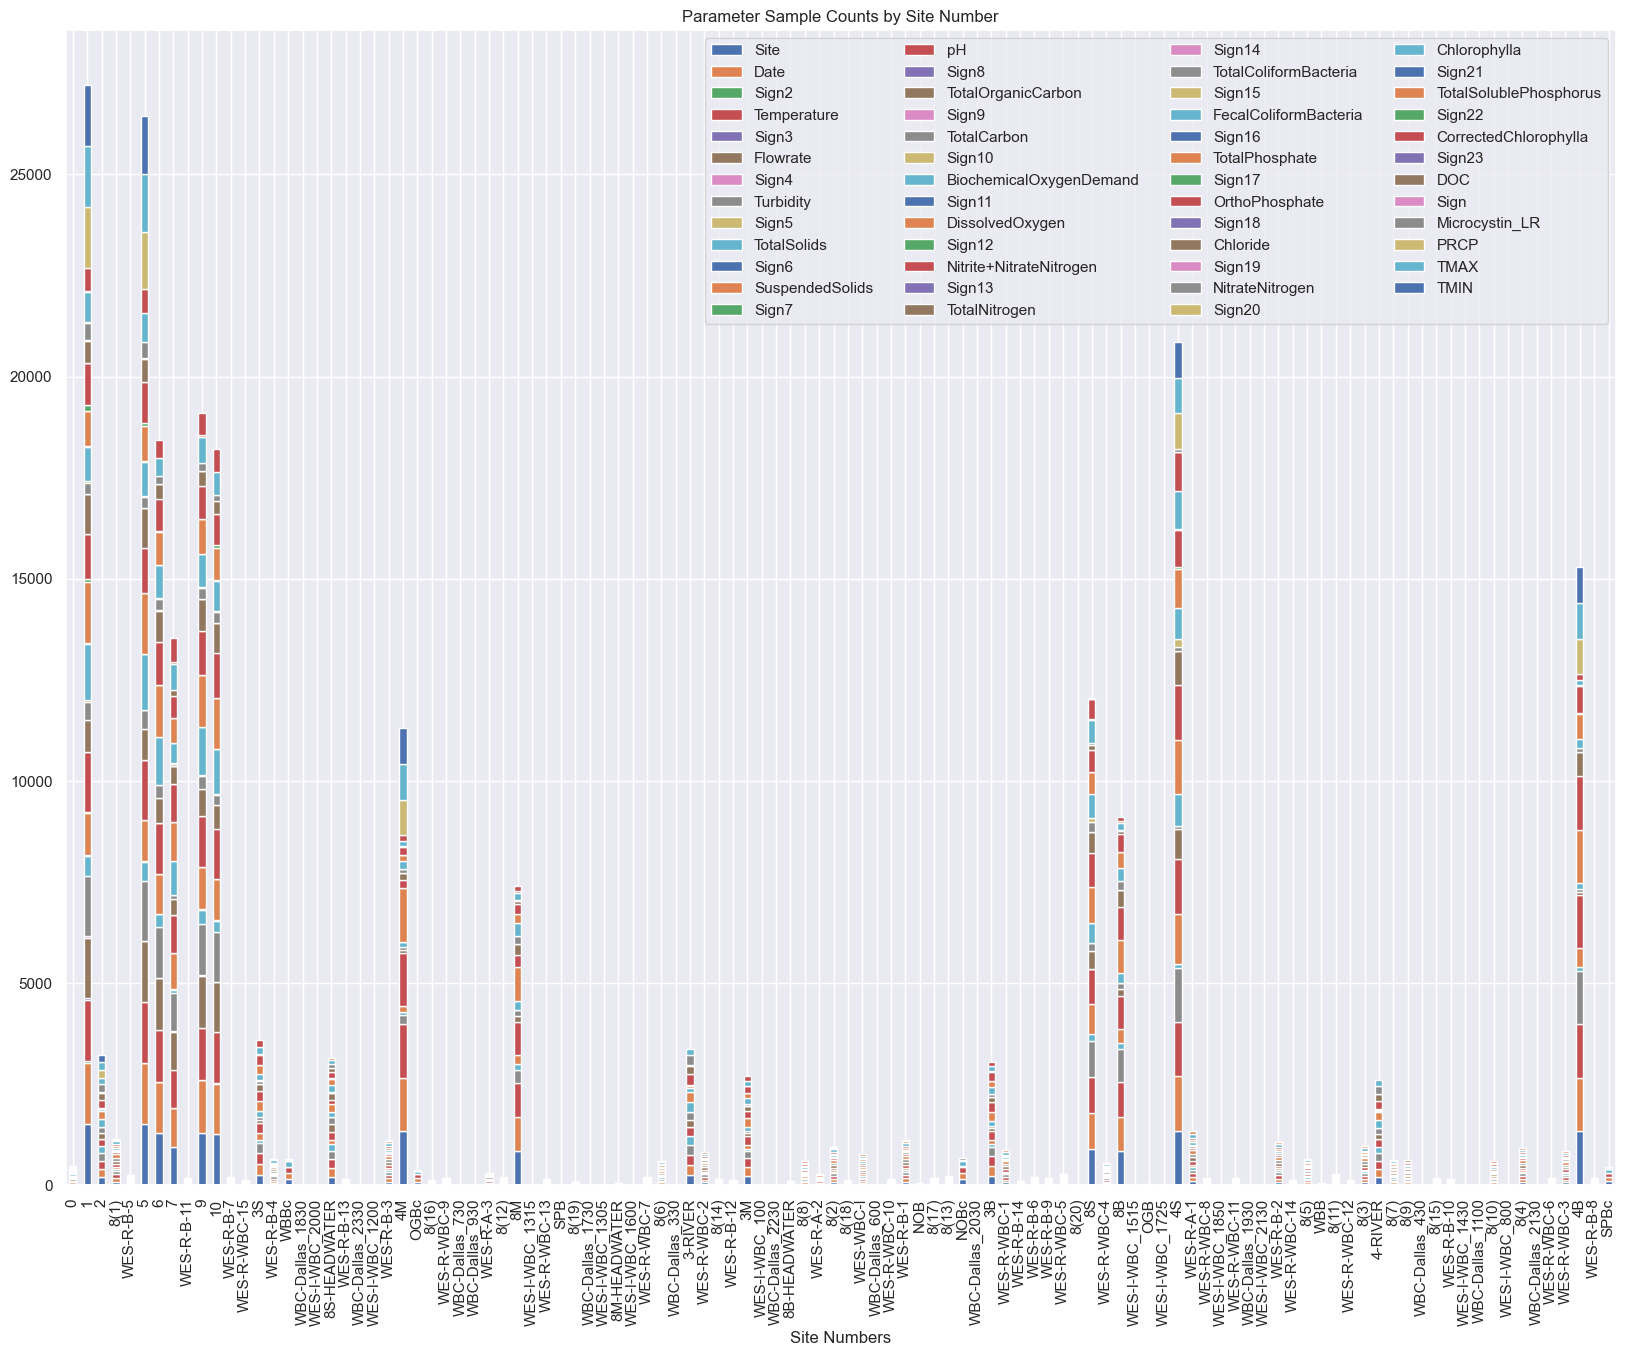

In [34]:
ax = count_df.plot(x='Site Numbers',
                   kind = 'bar',
                   stacked = True,
                   subplots = False,
                   title = 'Parameter Sample Counts by Site Number',
                   rot=90,
                   figsize = (20,15), )
plt.legend(loc='best', fancybox= True, ncol = 4)
plt.show()

In [35]:
print(len(count_df.columns))
print(len(site_numbers))

52
108


It is hard to create an effective visual because I have **108** different testing sites with **52** different columns. Let's split up our testing sites a little to make it easier to visualize.

In [36]:
def divide_list(l, n):
    '''This function will divide a list (l), such that each division contains a defined number (n) of items'''
    
    for i in range(0,len(l),n):
        yield l[i:i+n]

In [37]:
n= 9 #I chose a number that would divide the x axis evenly
agg_list = list(divide_list(site_numbers, n))

In [38]:
fig_list = list()

outer_index = 0

while outer_index < n:
    inner_index = 0
    output = pd.DataFrame()
    
    for item in agg_list[outer_index]:
            temp = count_df[count_df['Site Numbers'] == agg_list[outer_index][inner_index]]
            output = pd.concat([output,temp])
            inner_index = inner_index+1
            
    fig_list.append(output)
    outer_index = outer_index +1


Now that we've split up our dataframes into more palatable amounts of sites per figure, let's see if we can get a better graph to visualize how much data we have.

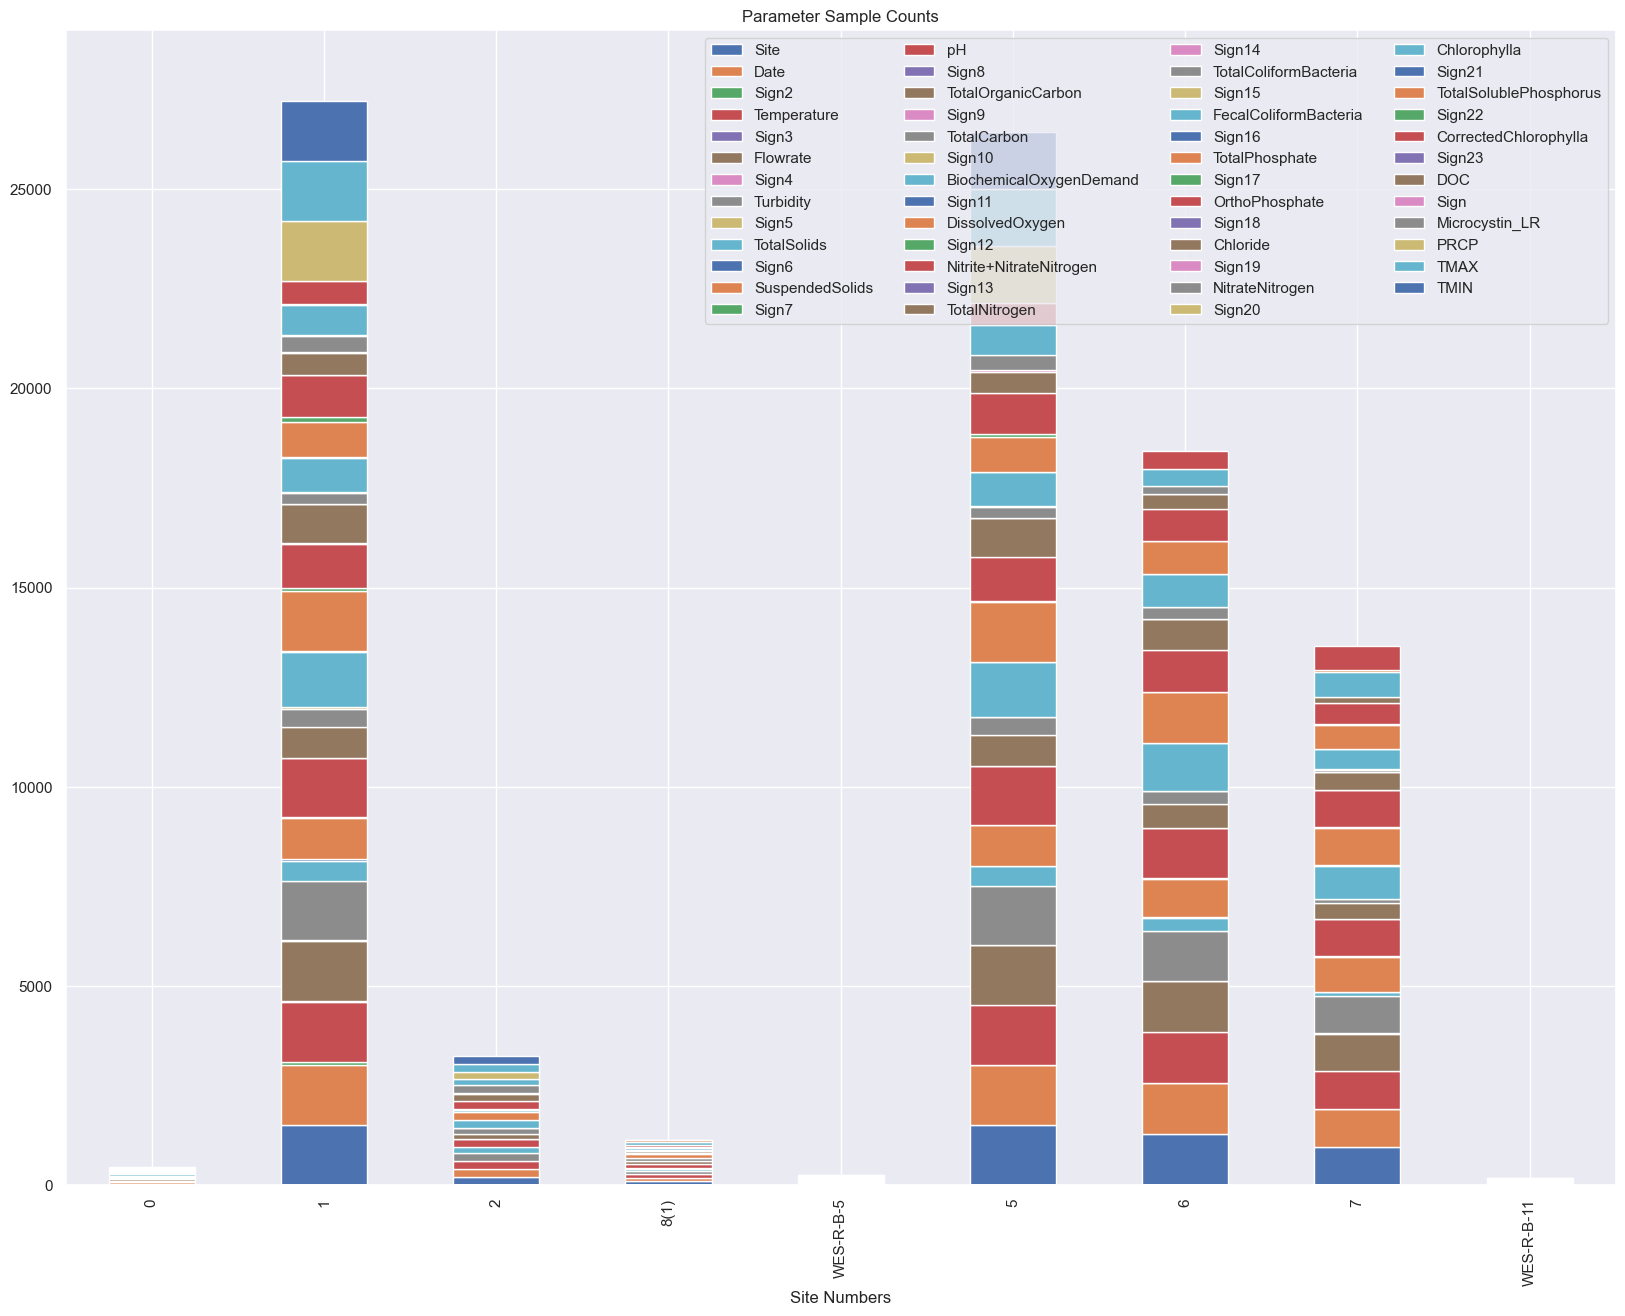

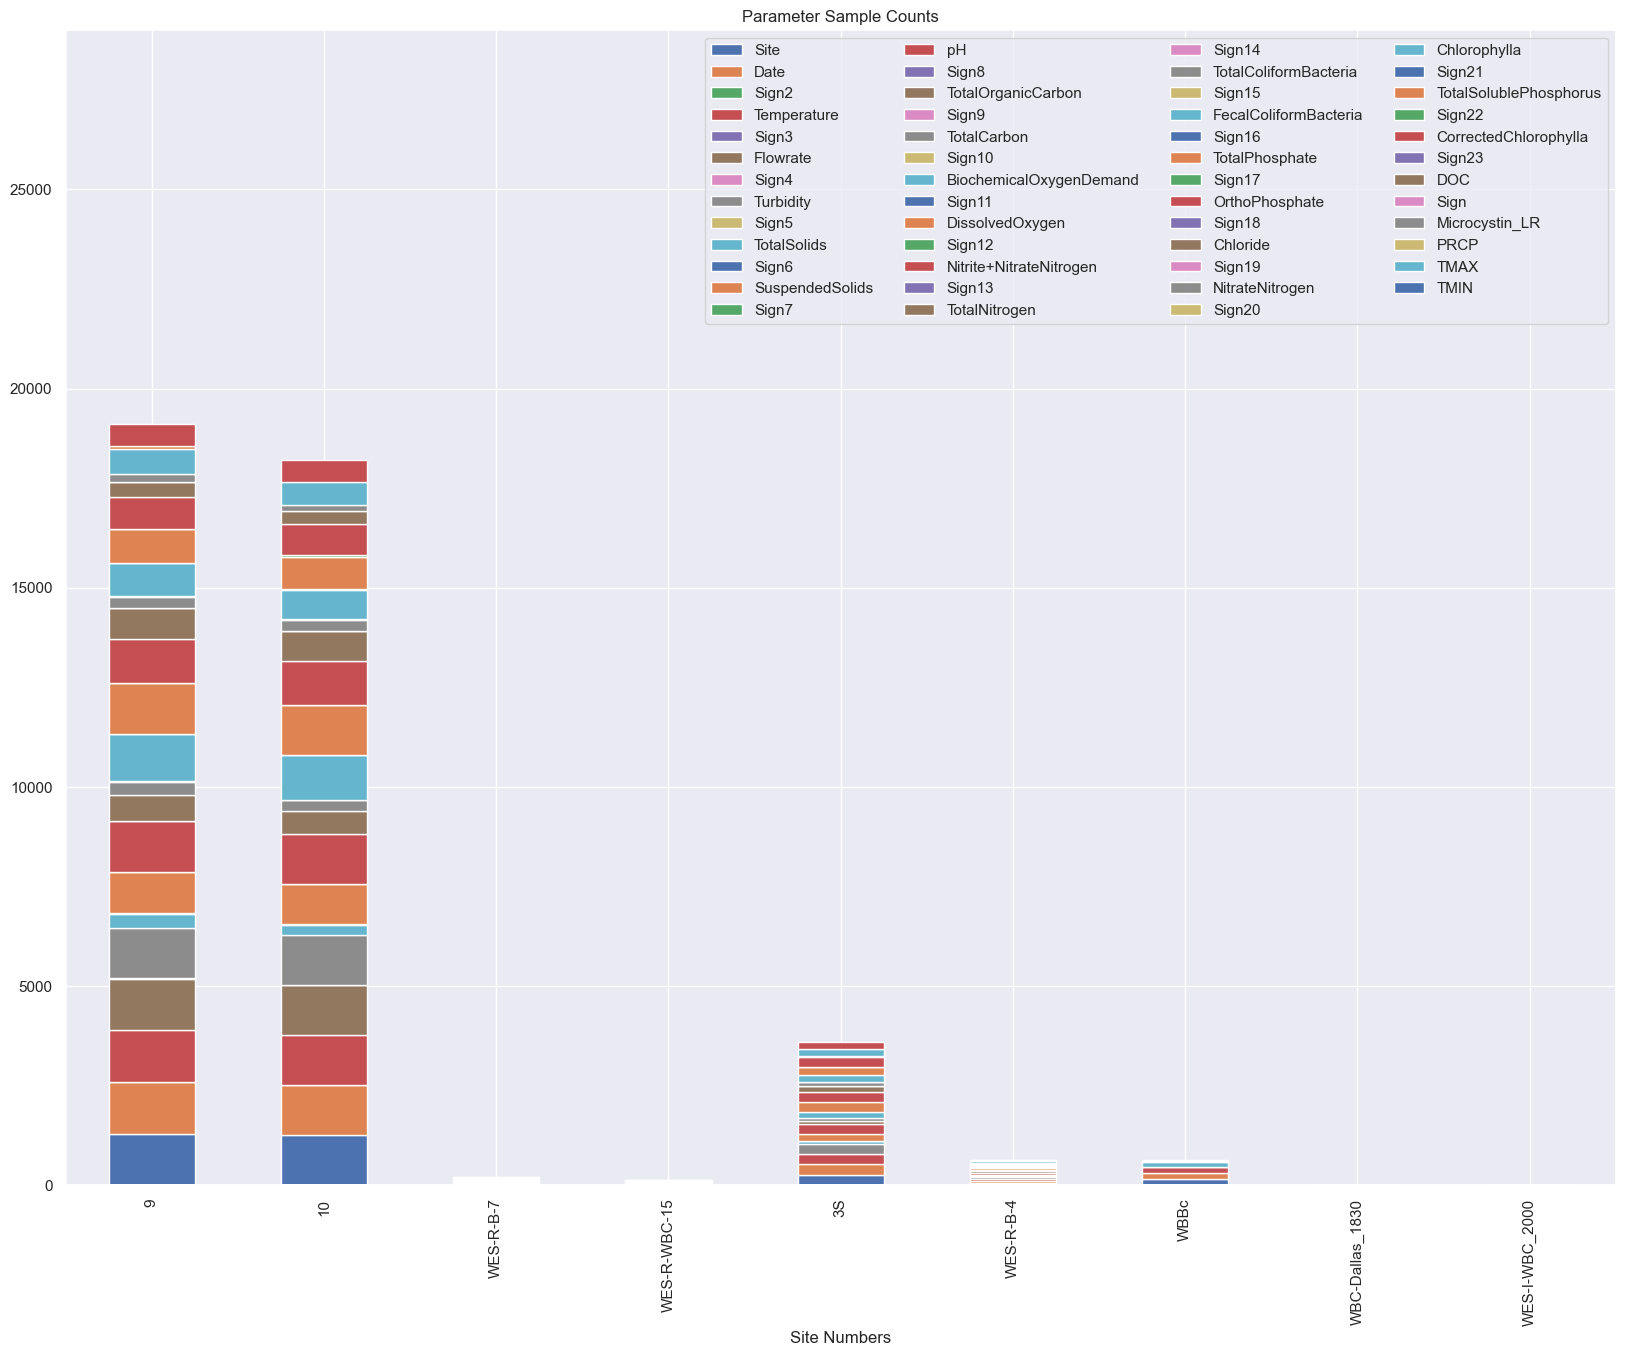

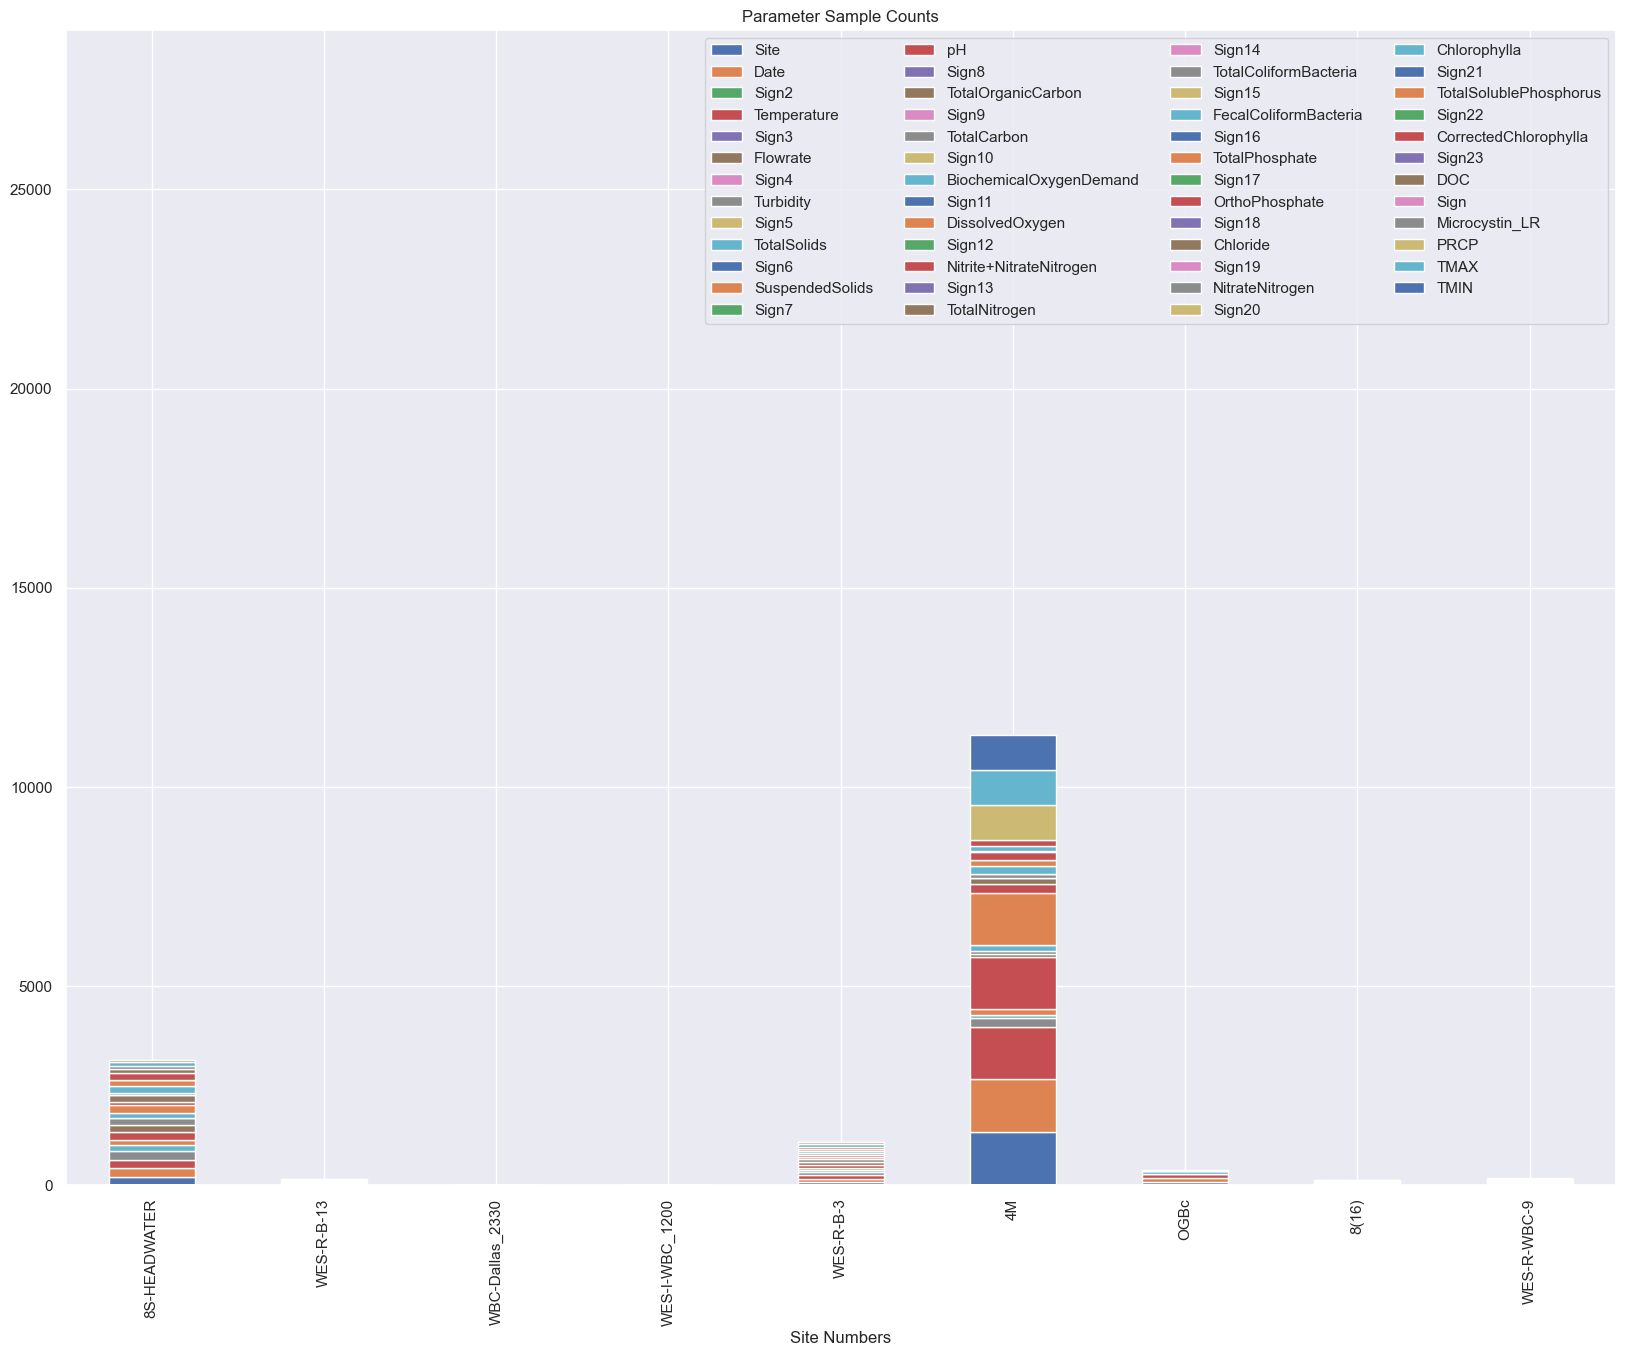

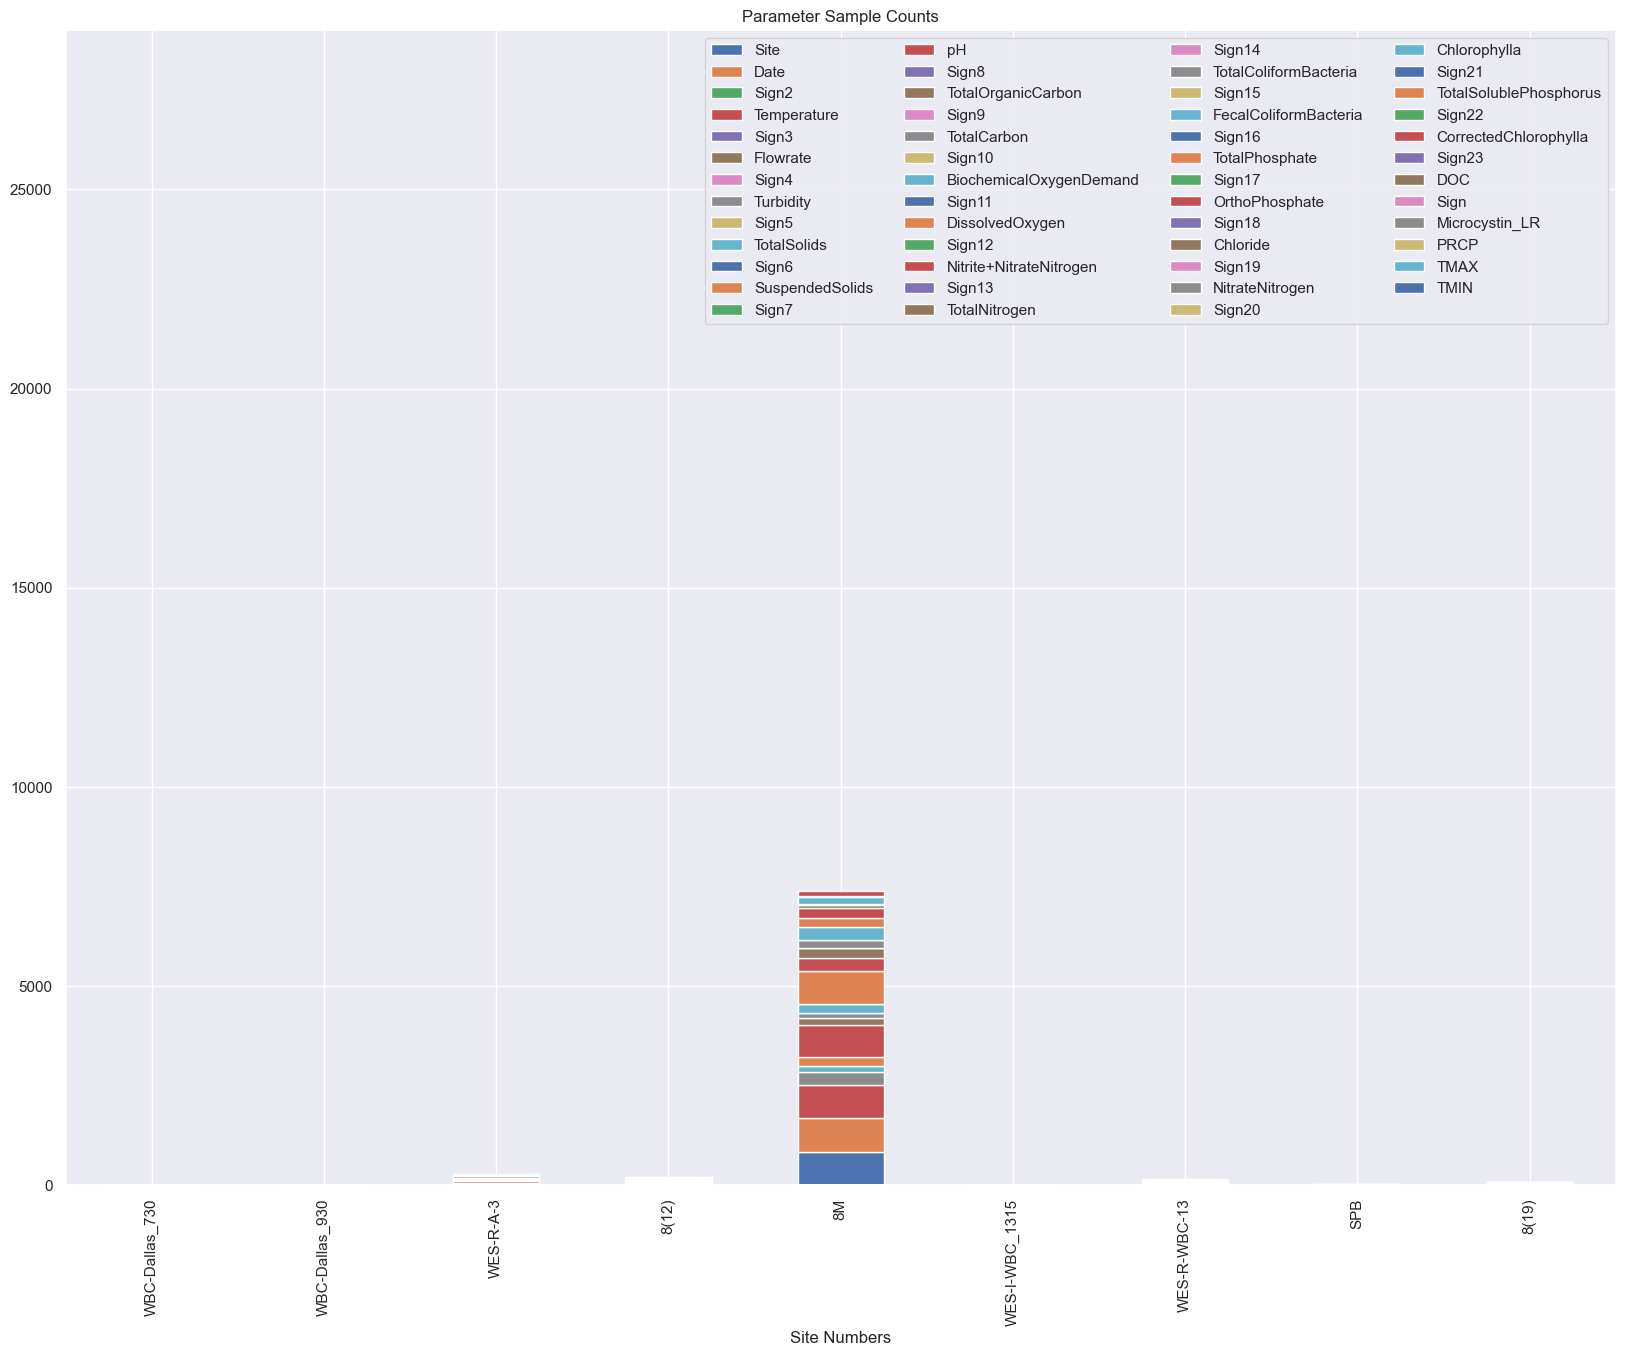

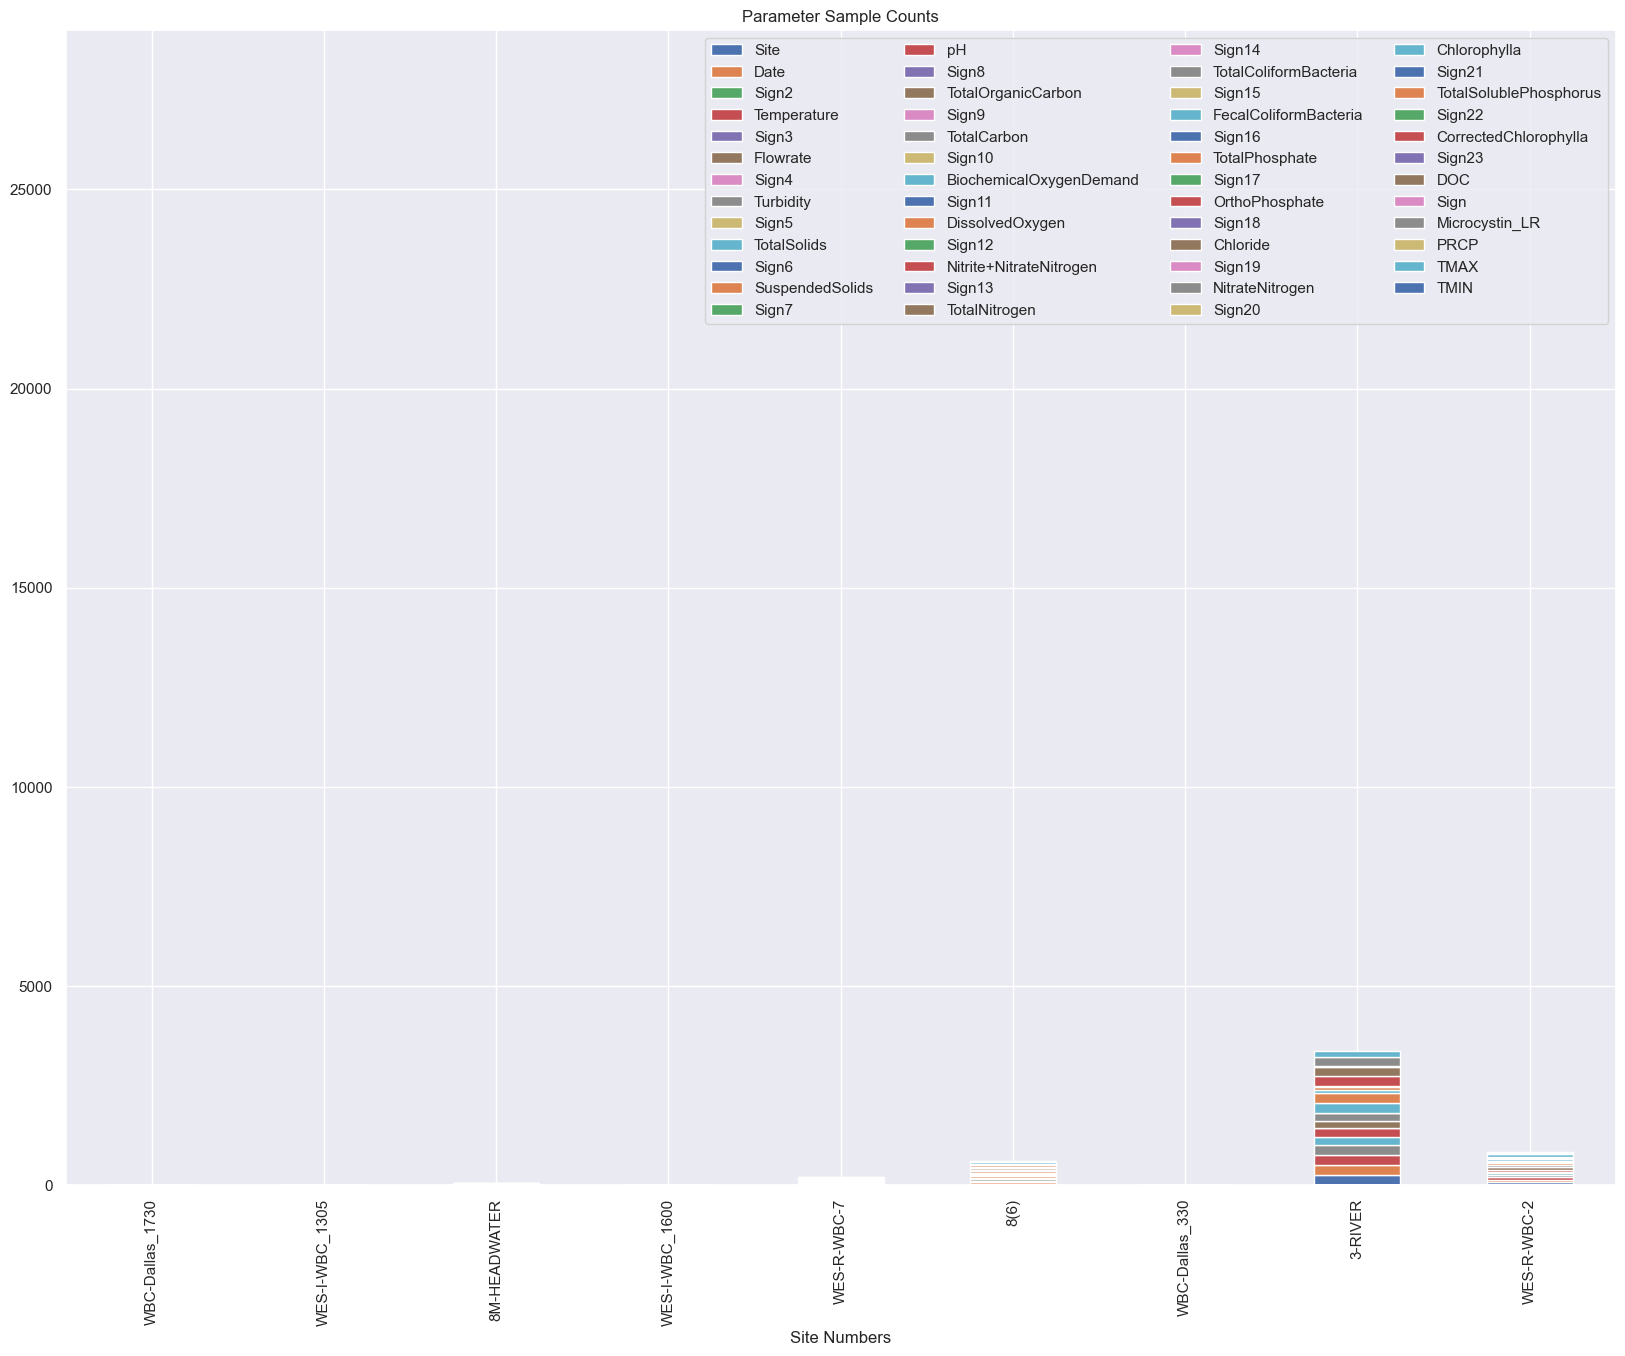

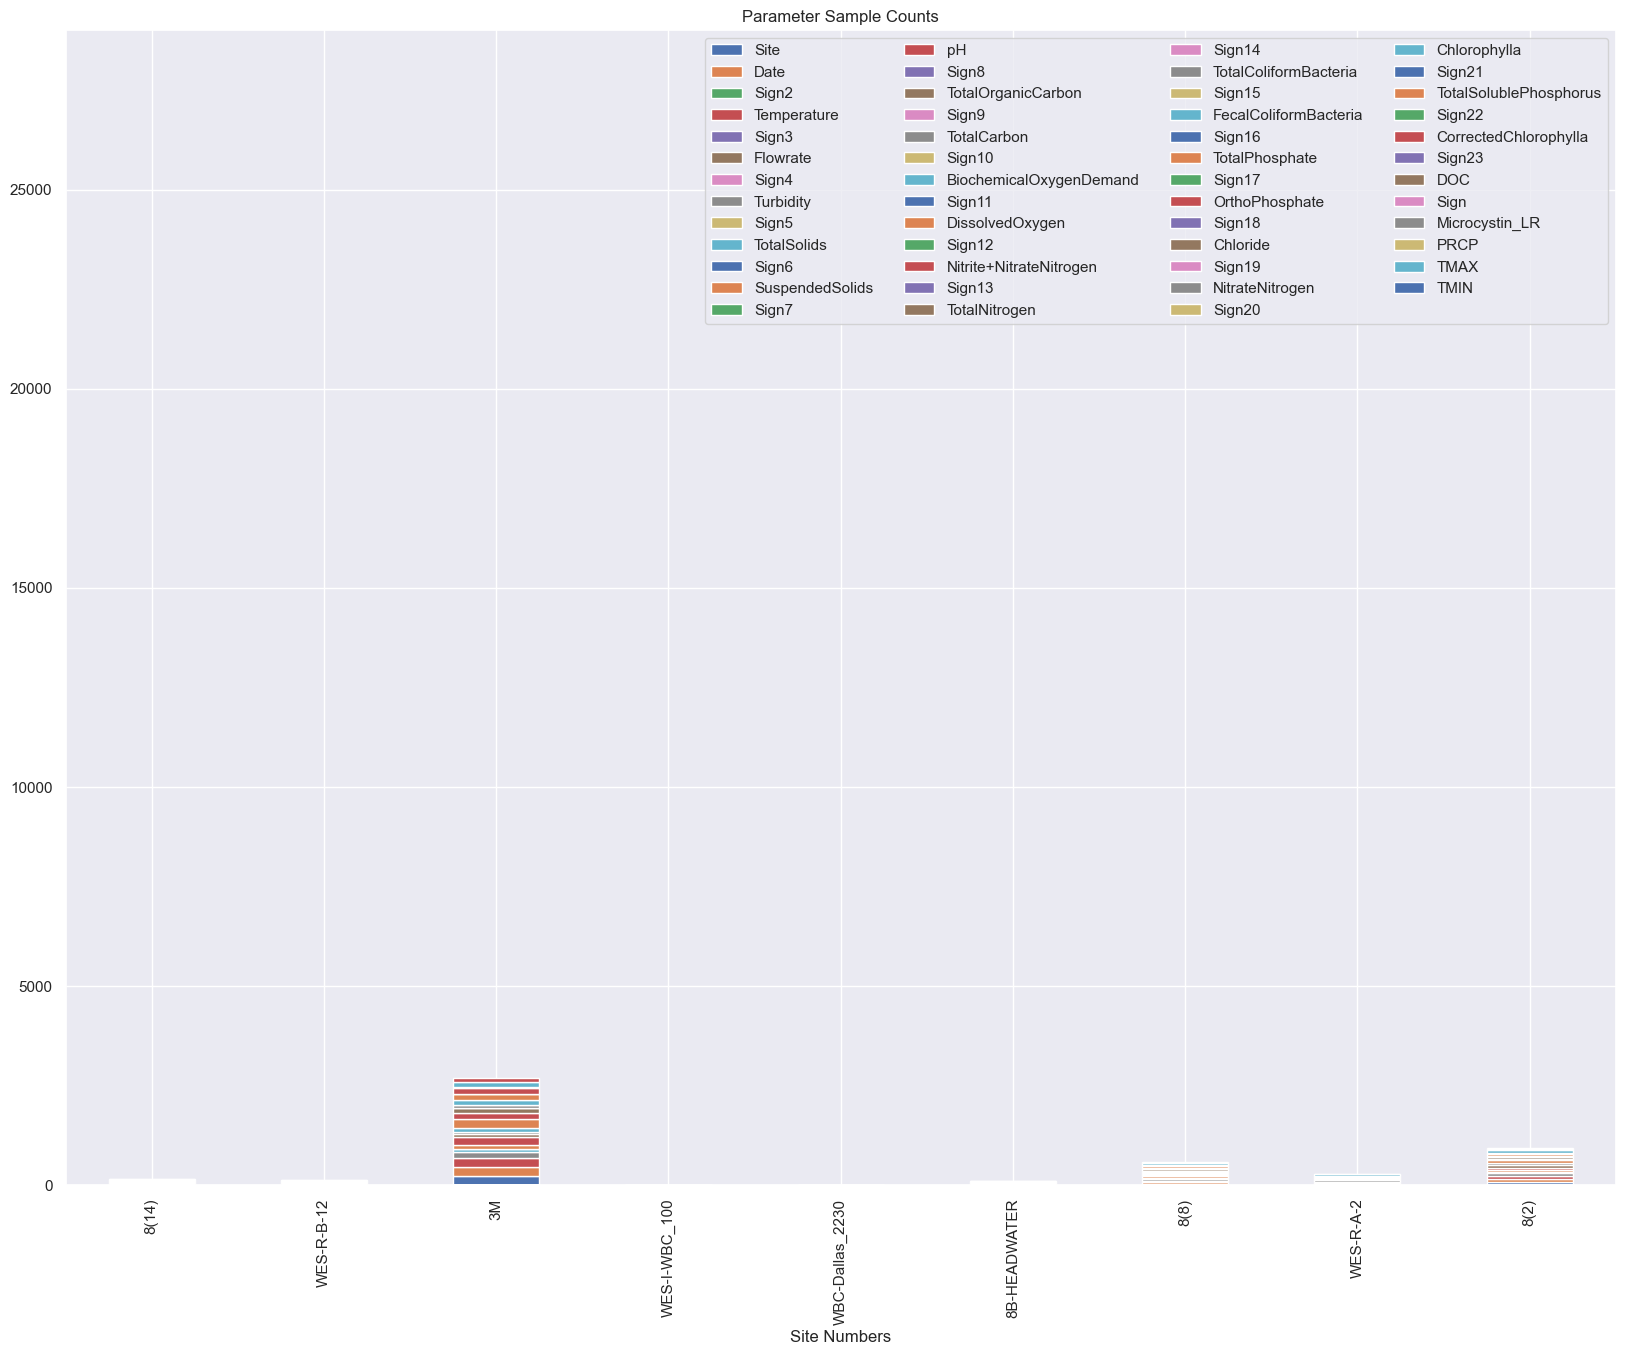

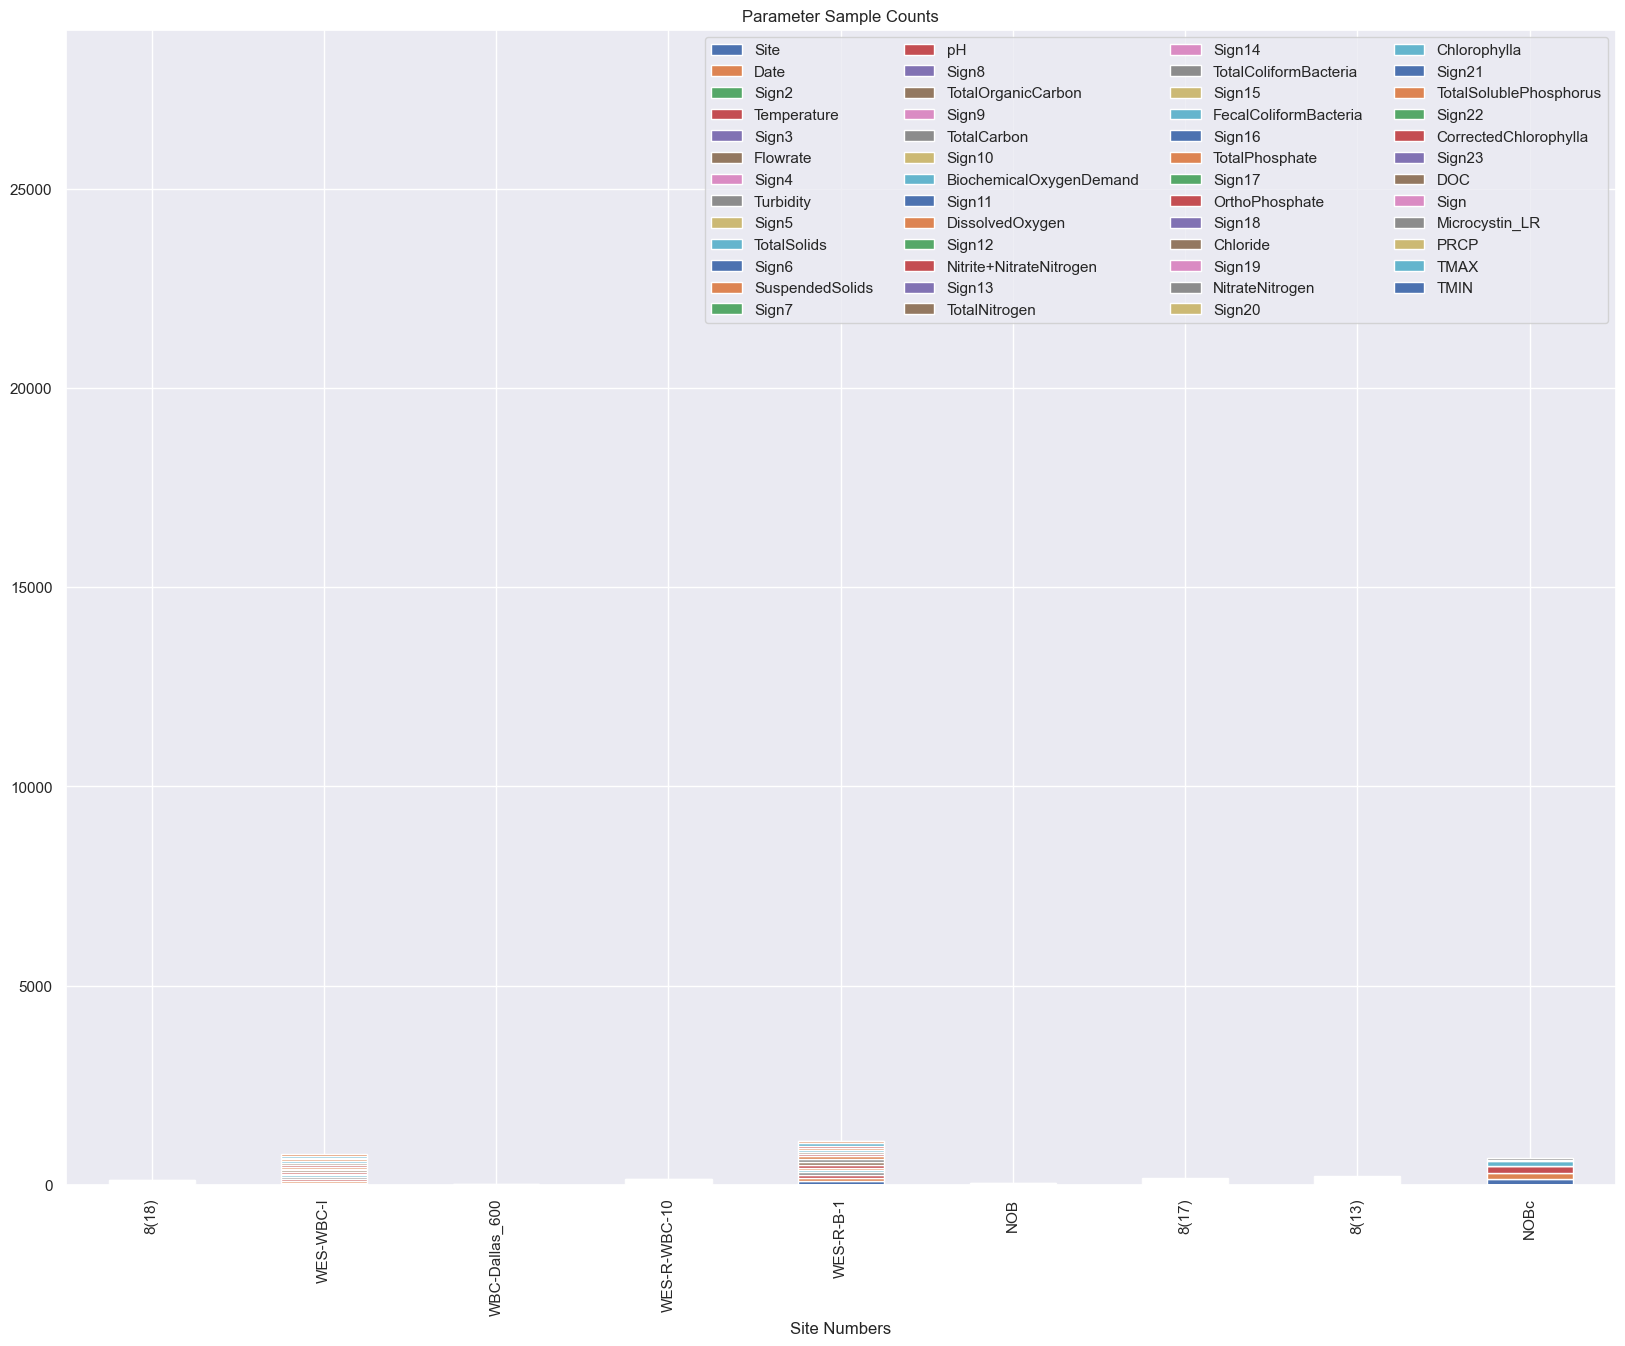

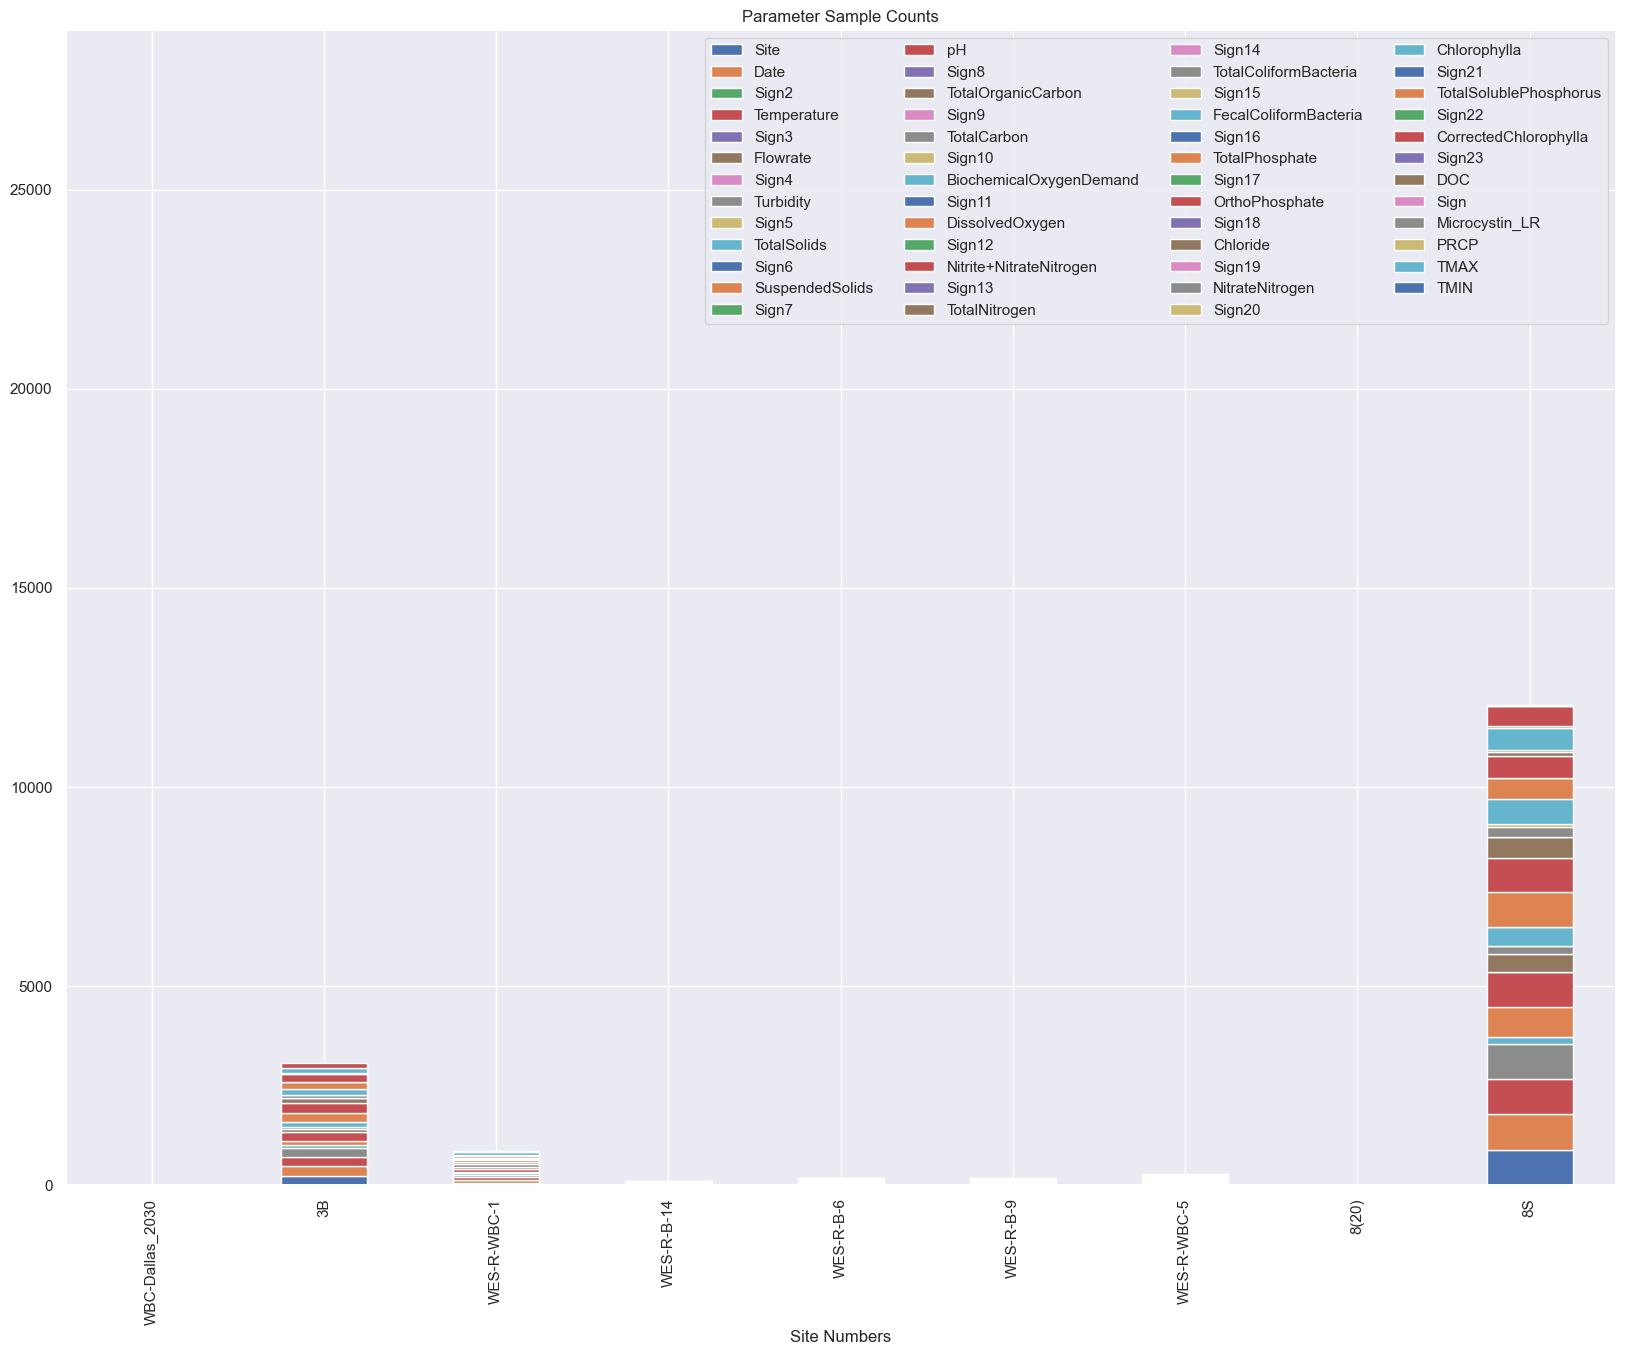

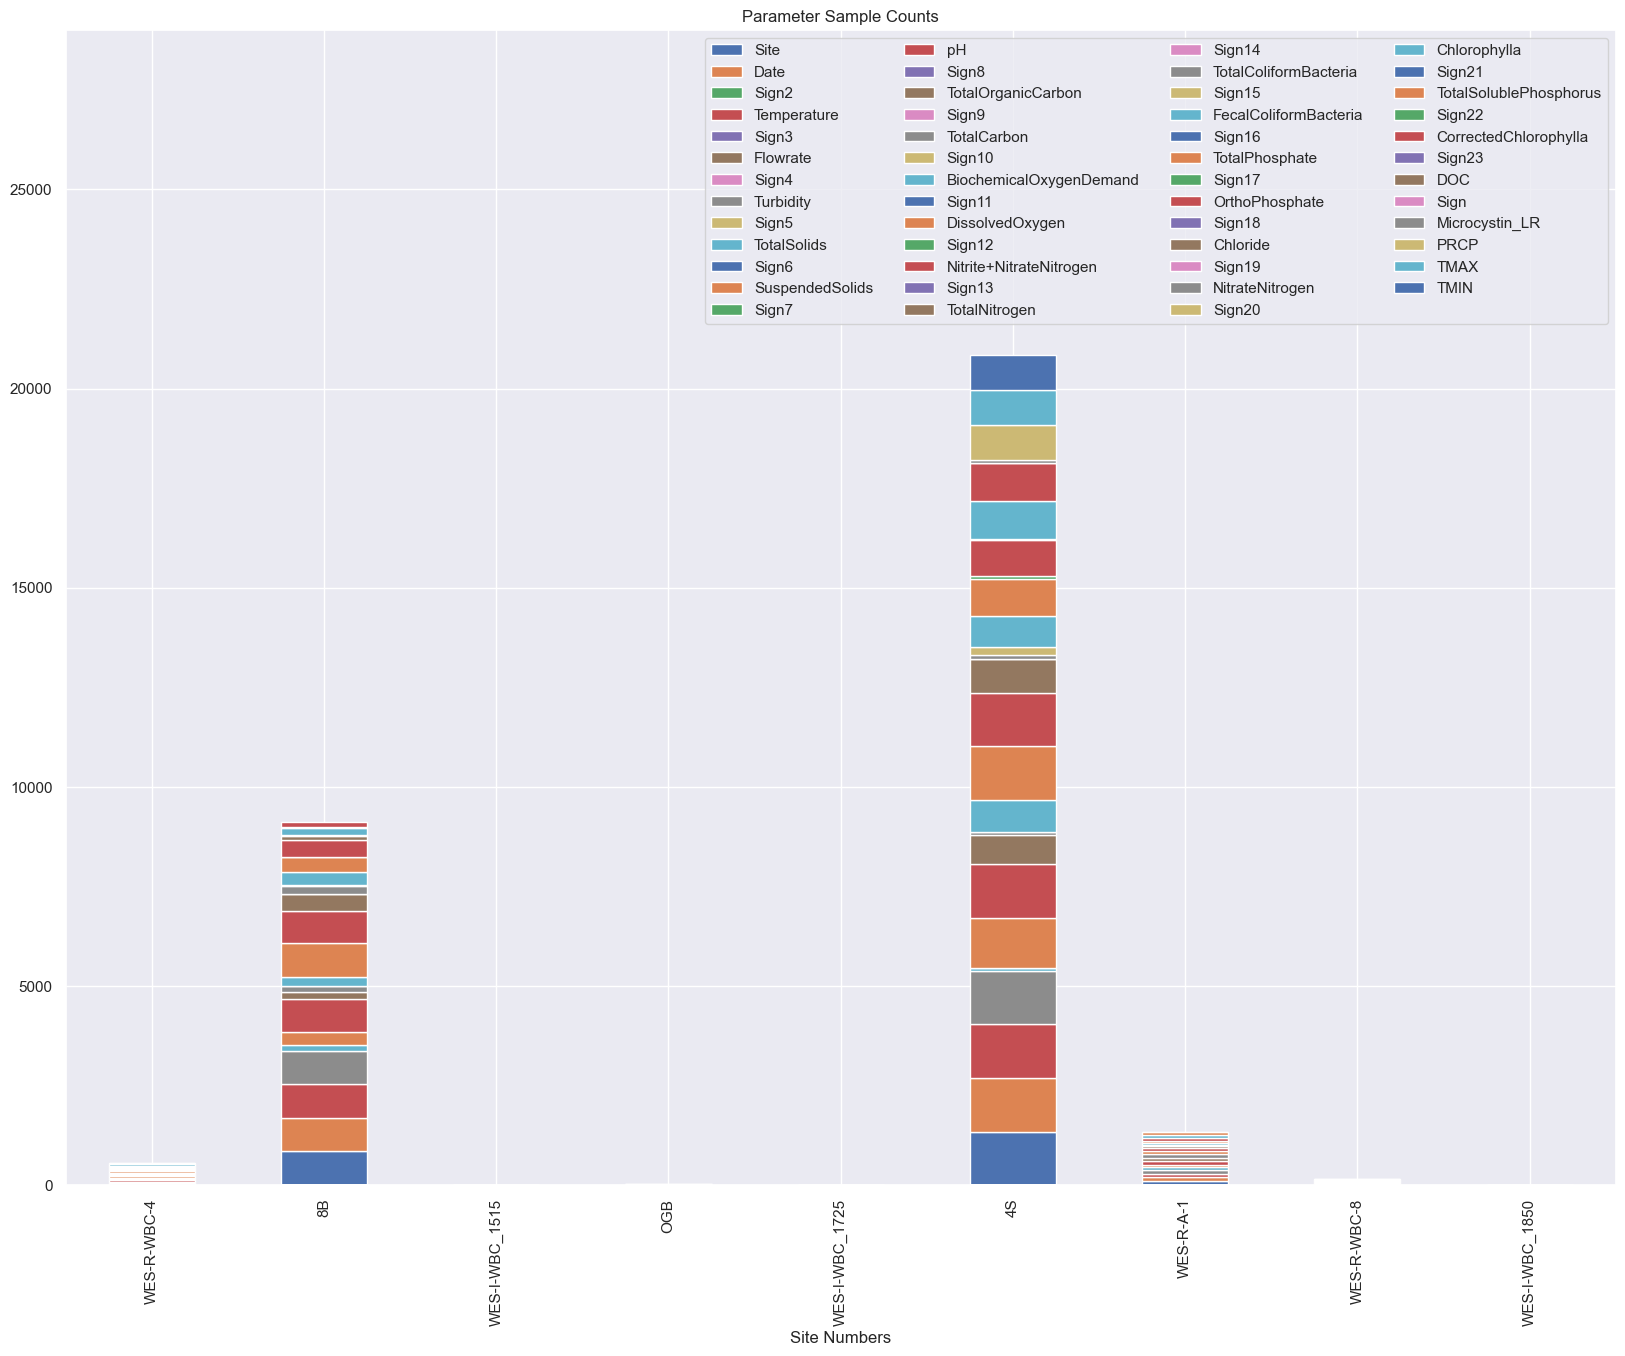

In [39]:
name_id=0

for df in fig_list:
    loop_df = df
    ax = loop_df.plot(x='Site Numbers',
                kind = 'bar',
                stacked = True,
                subplots = False,
                title = 'Parameter Sample Counts',
                rot=90,
                ylim = (0, 29000),
                figsize = (20,15), )
    plt.legend(loc='best', fancybox= True, ncol = 4)
    plt.savefig('stackedbar'+str(name_id)+'.png')
    name_id +=1
    plt.show()

If you wish, open up the folder where this notebook is operating and you should find each stacked barplot saved as "stackedbar#.png"

Stacked bar plot is good, but not great, because we're limited on colors. Let's split it up into subplots to make it easier.

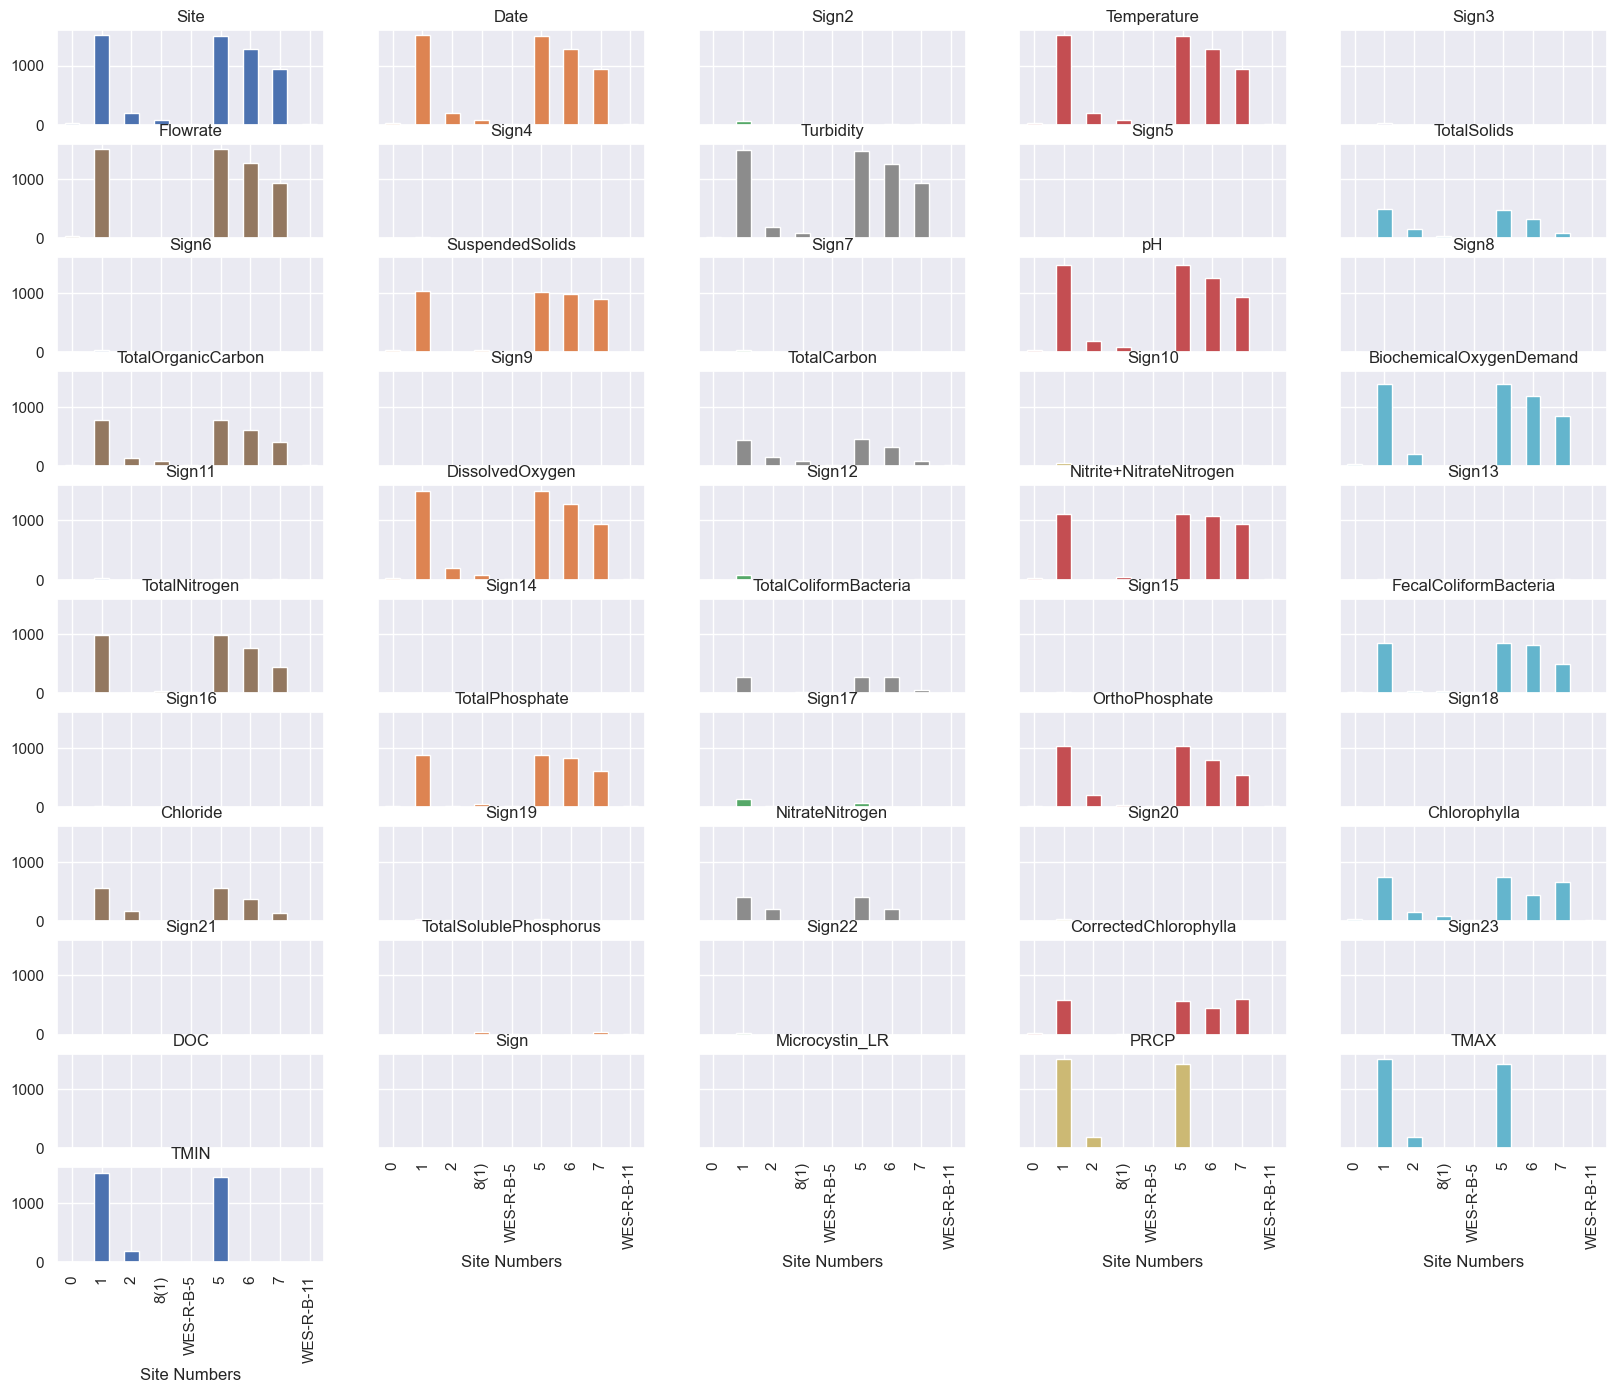

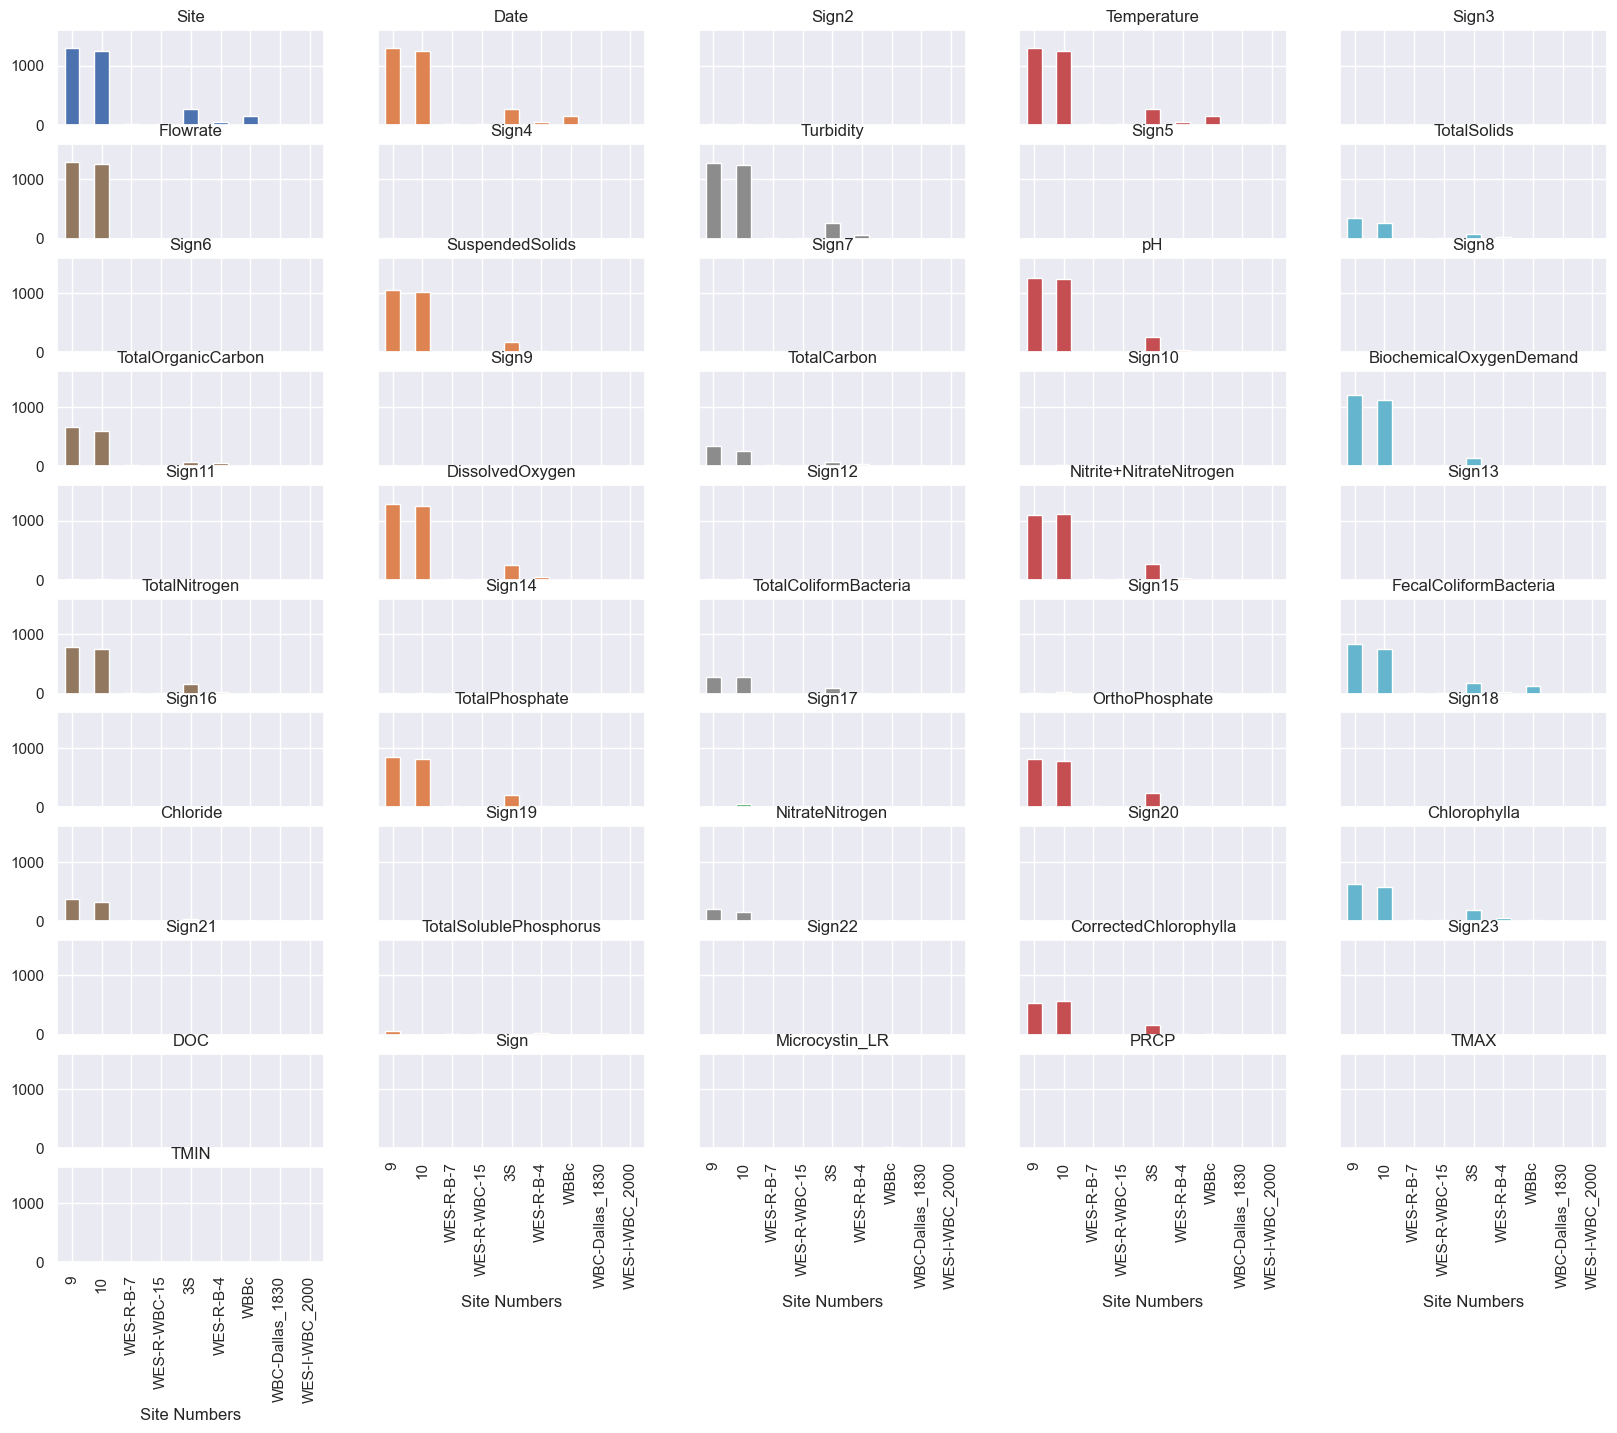

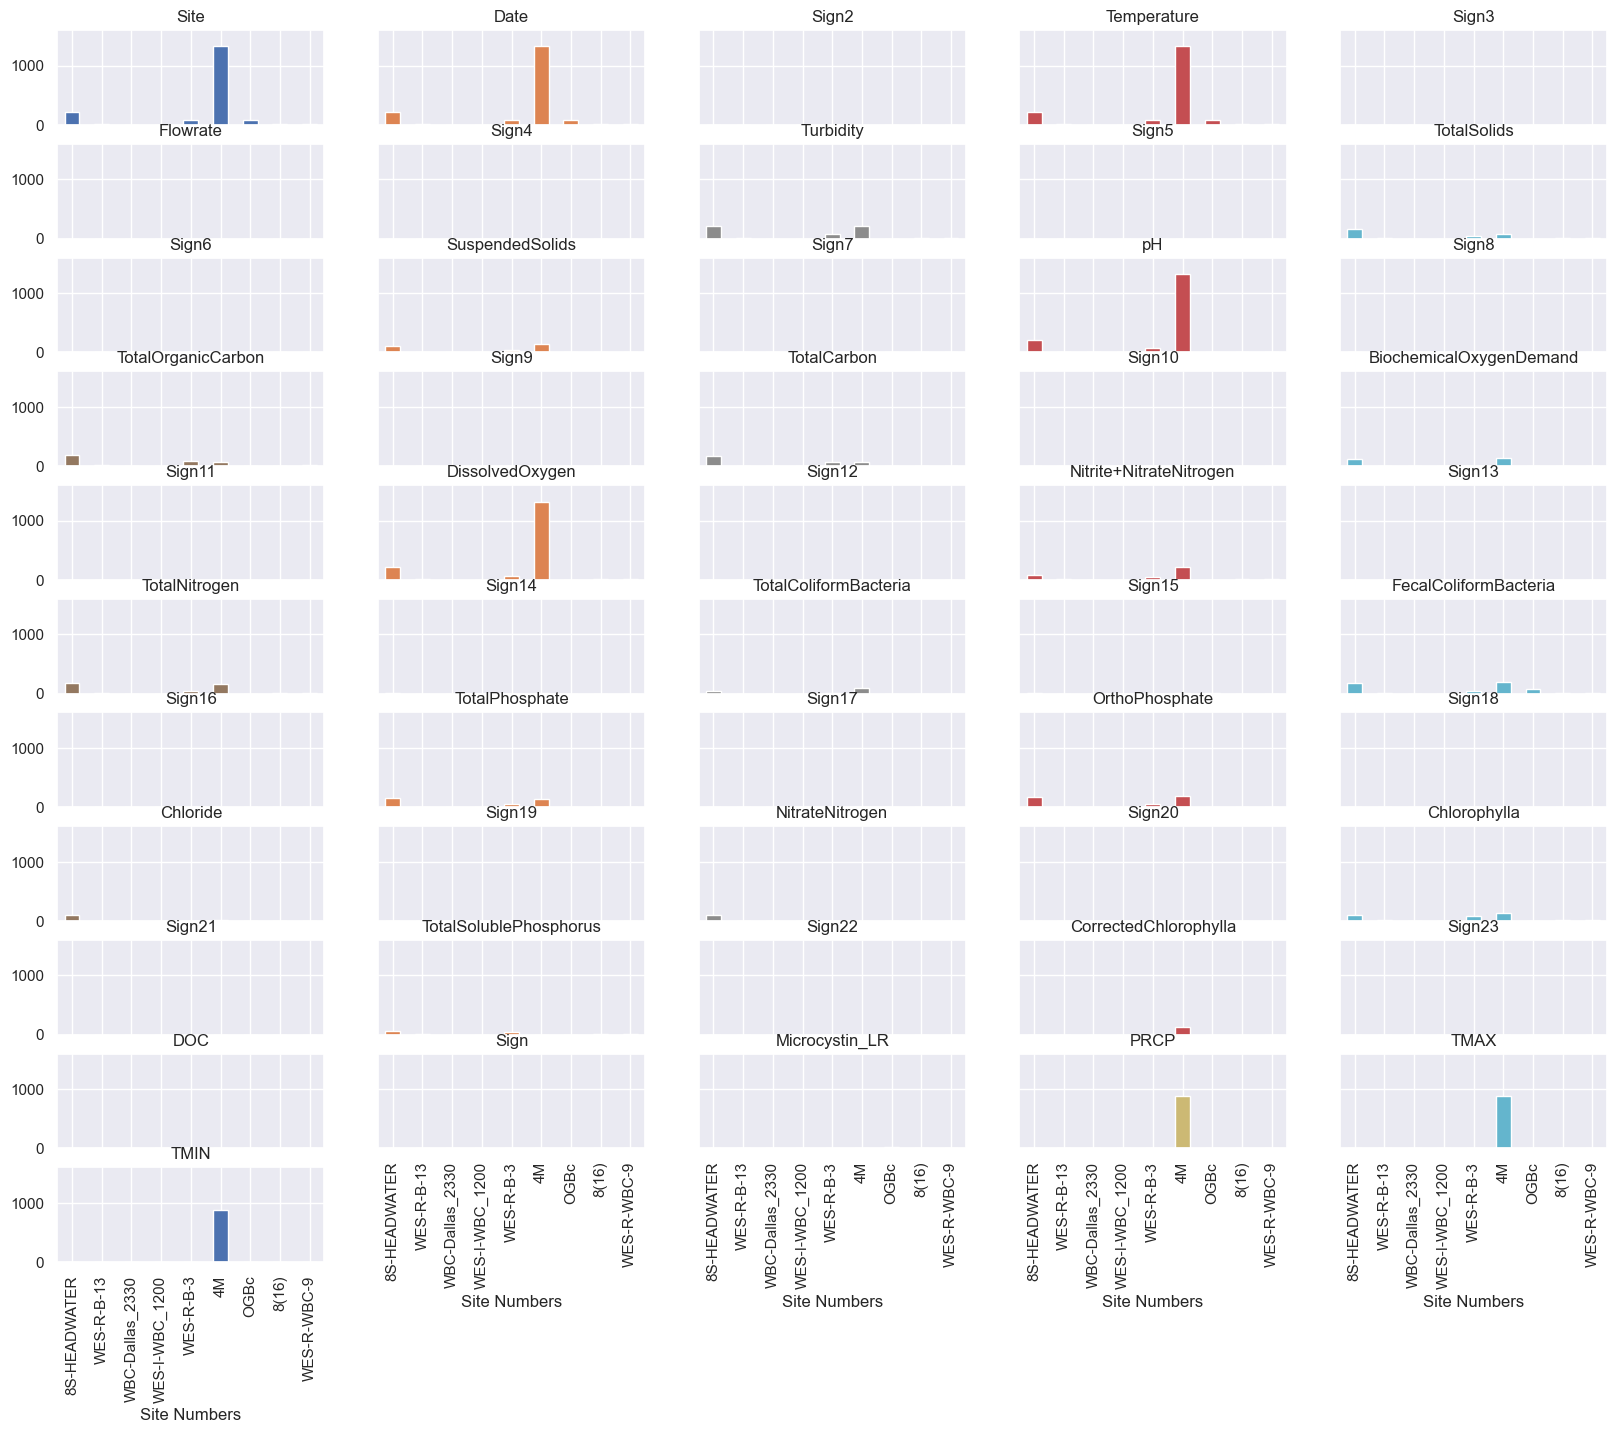

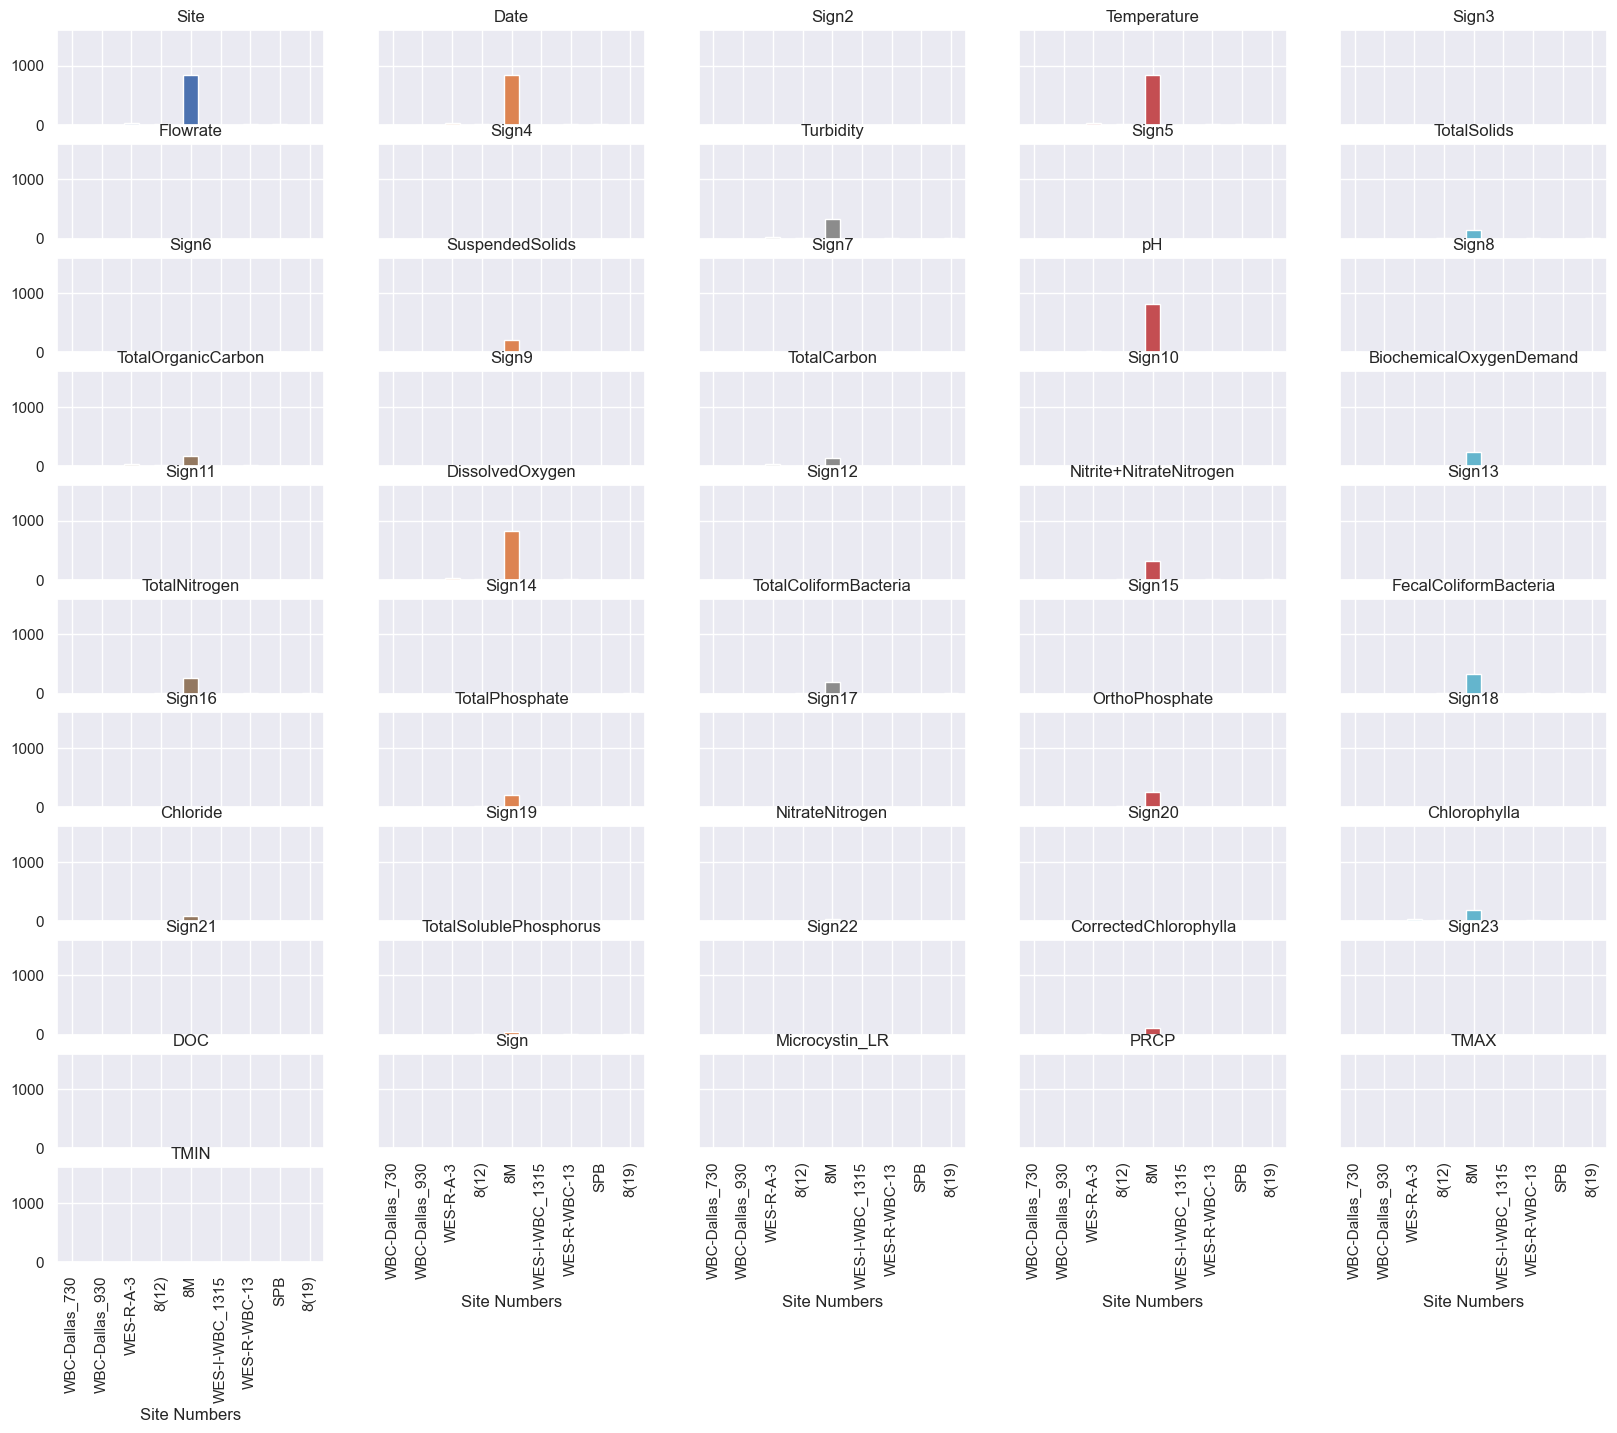

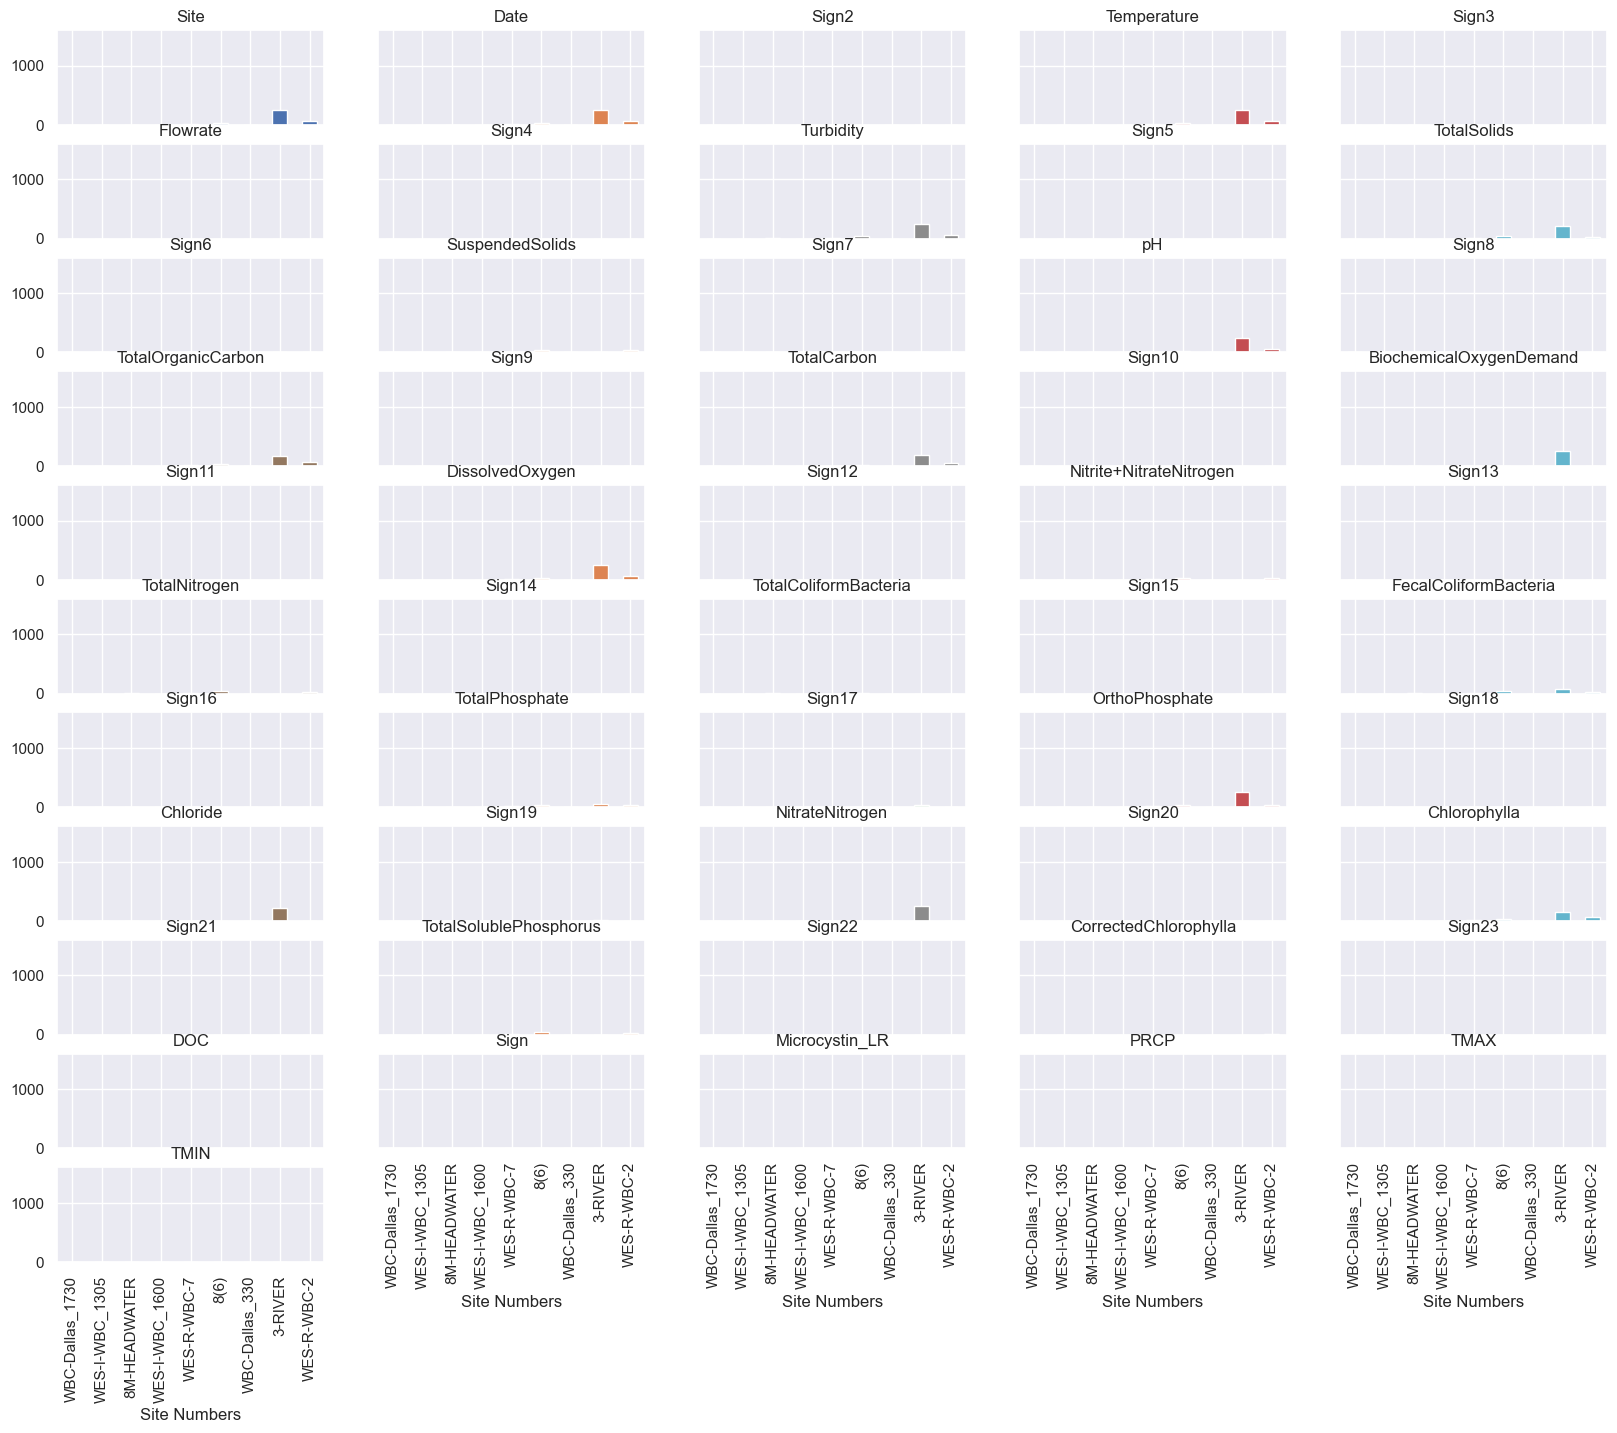

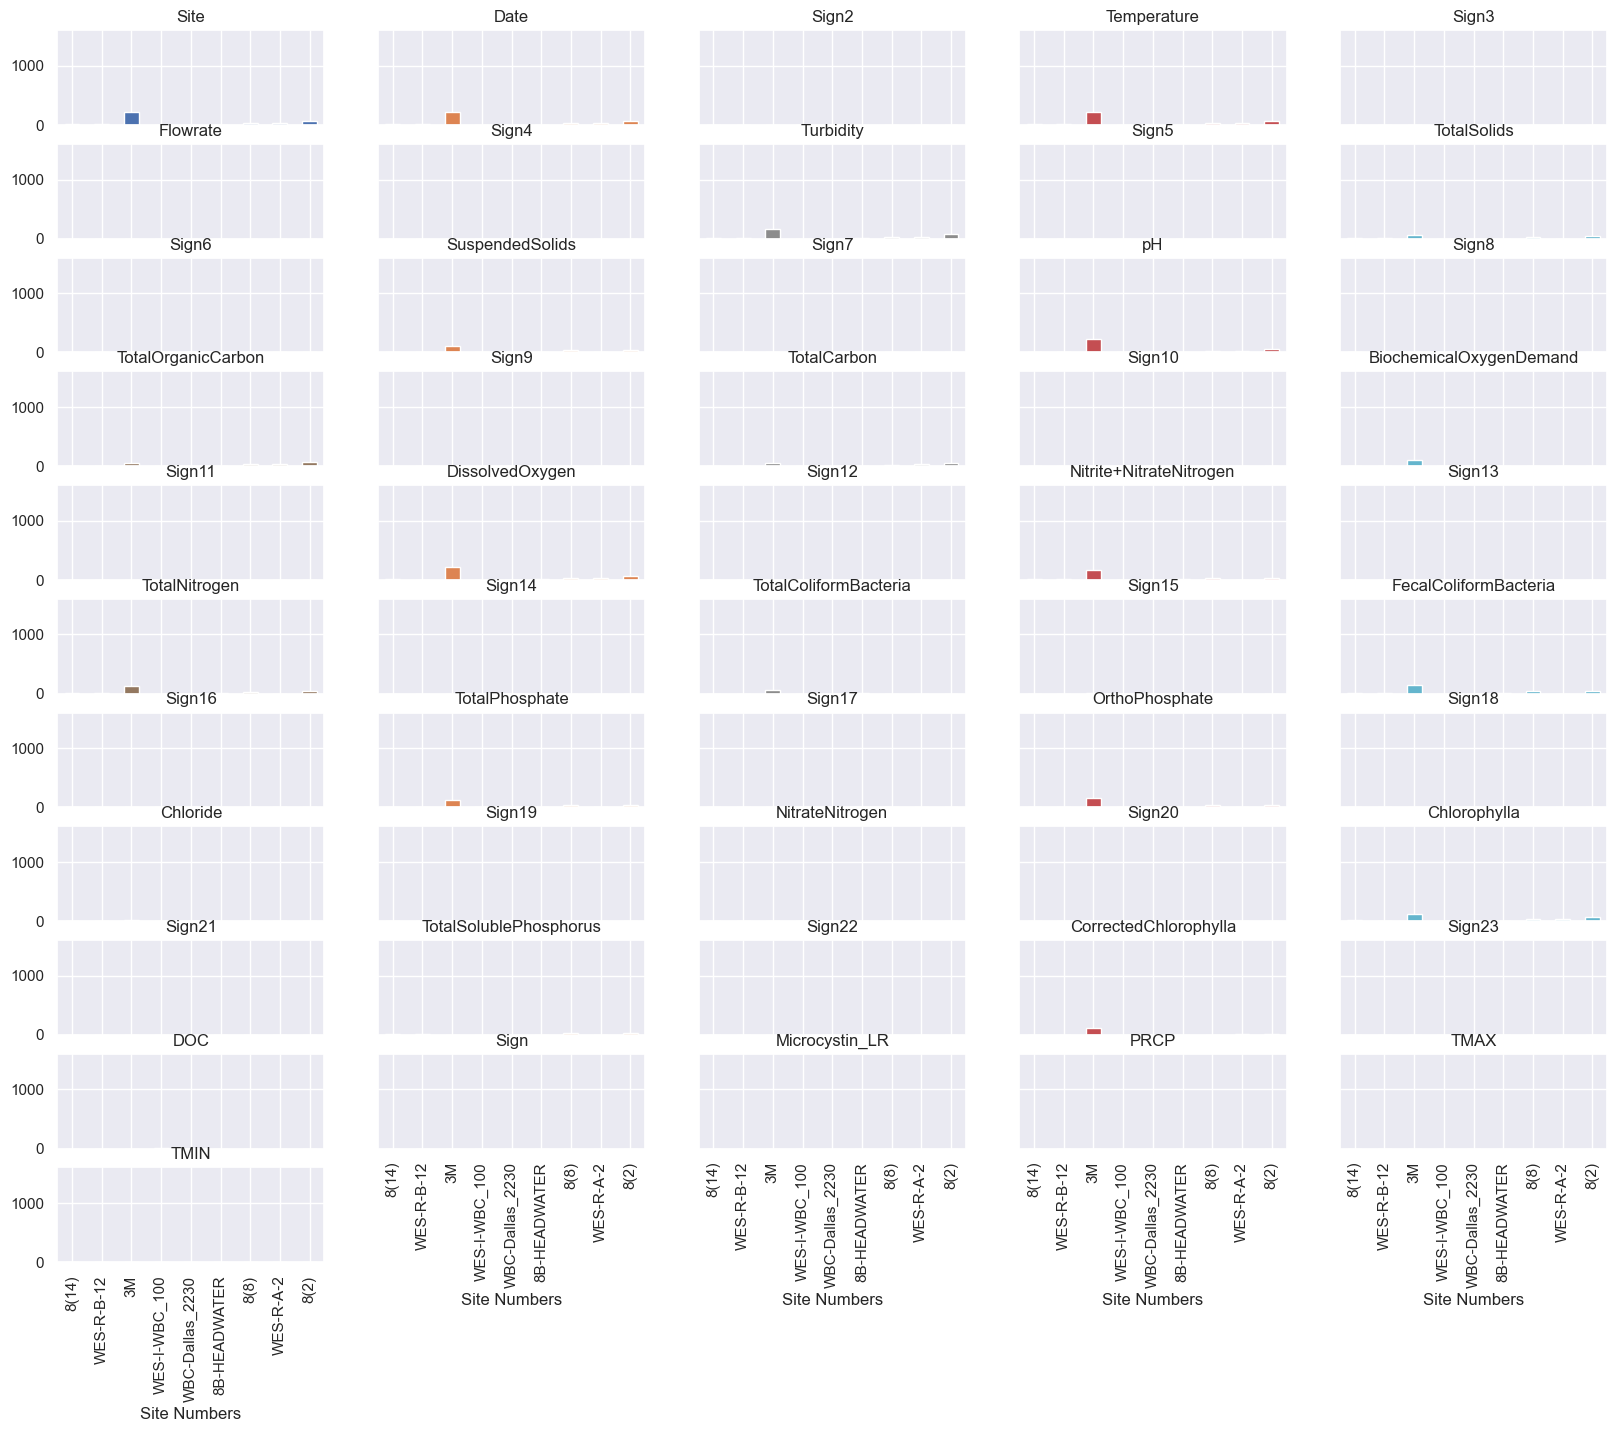

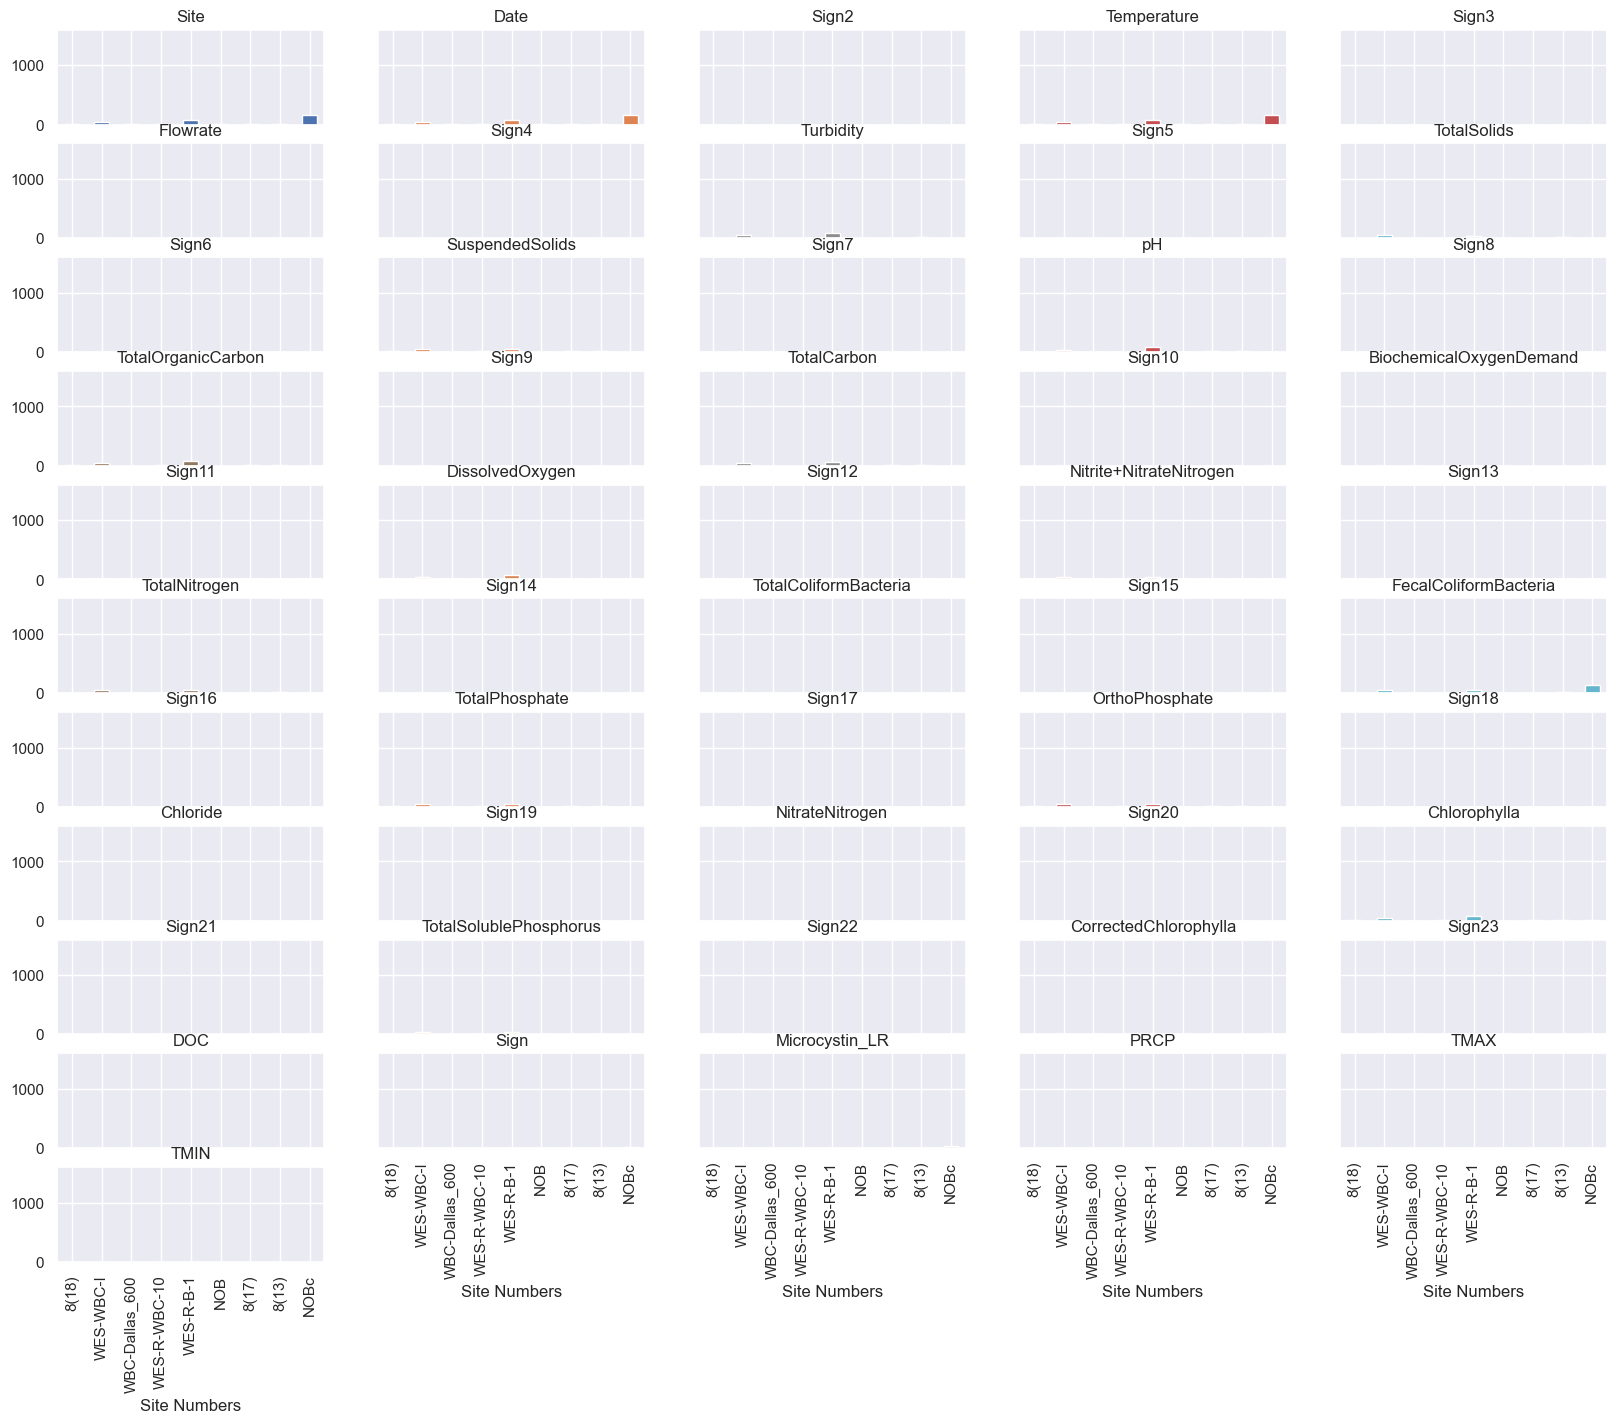

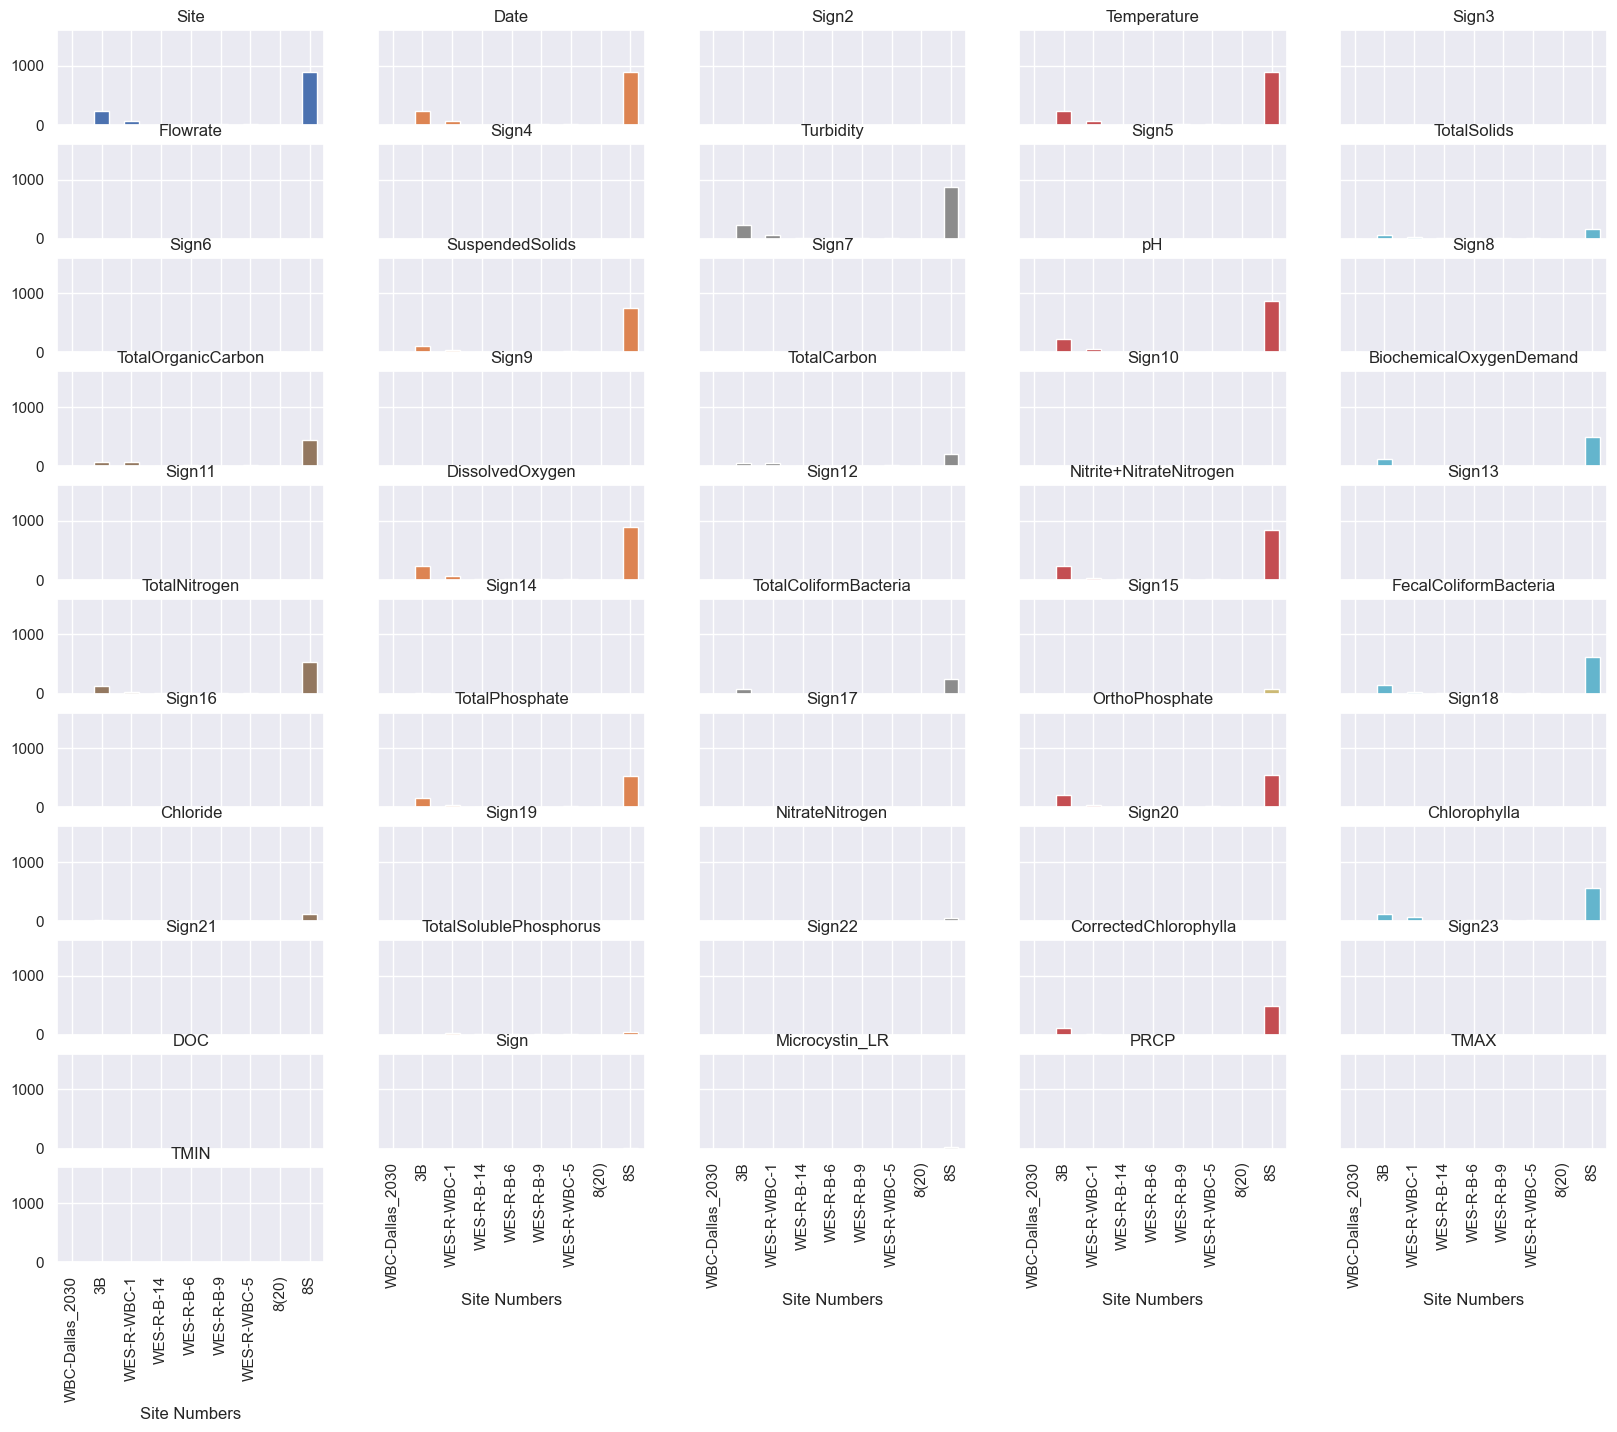

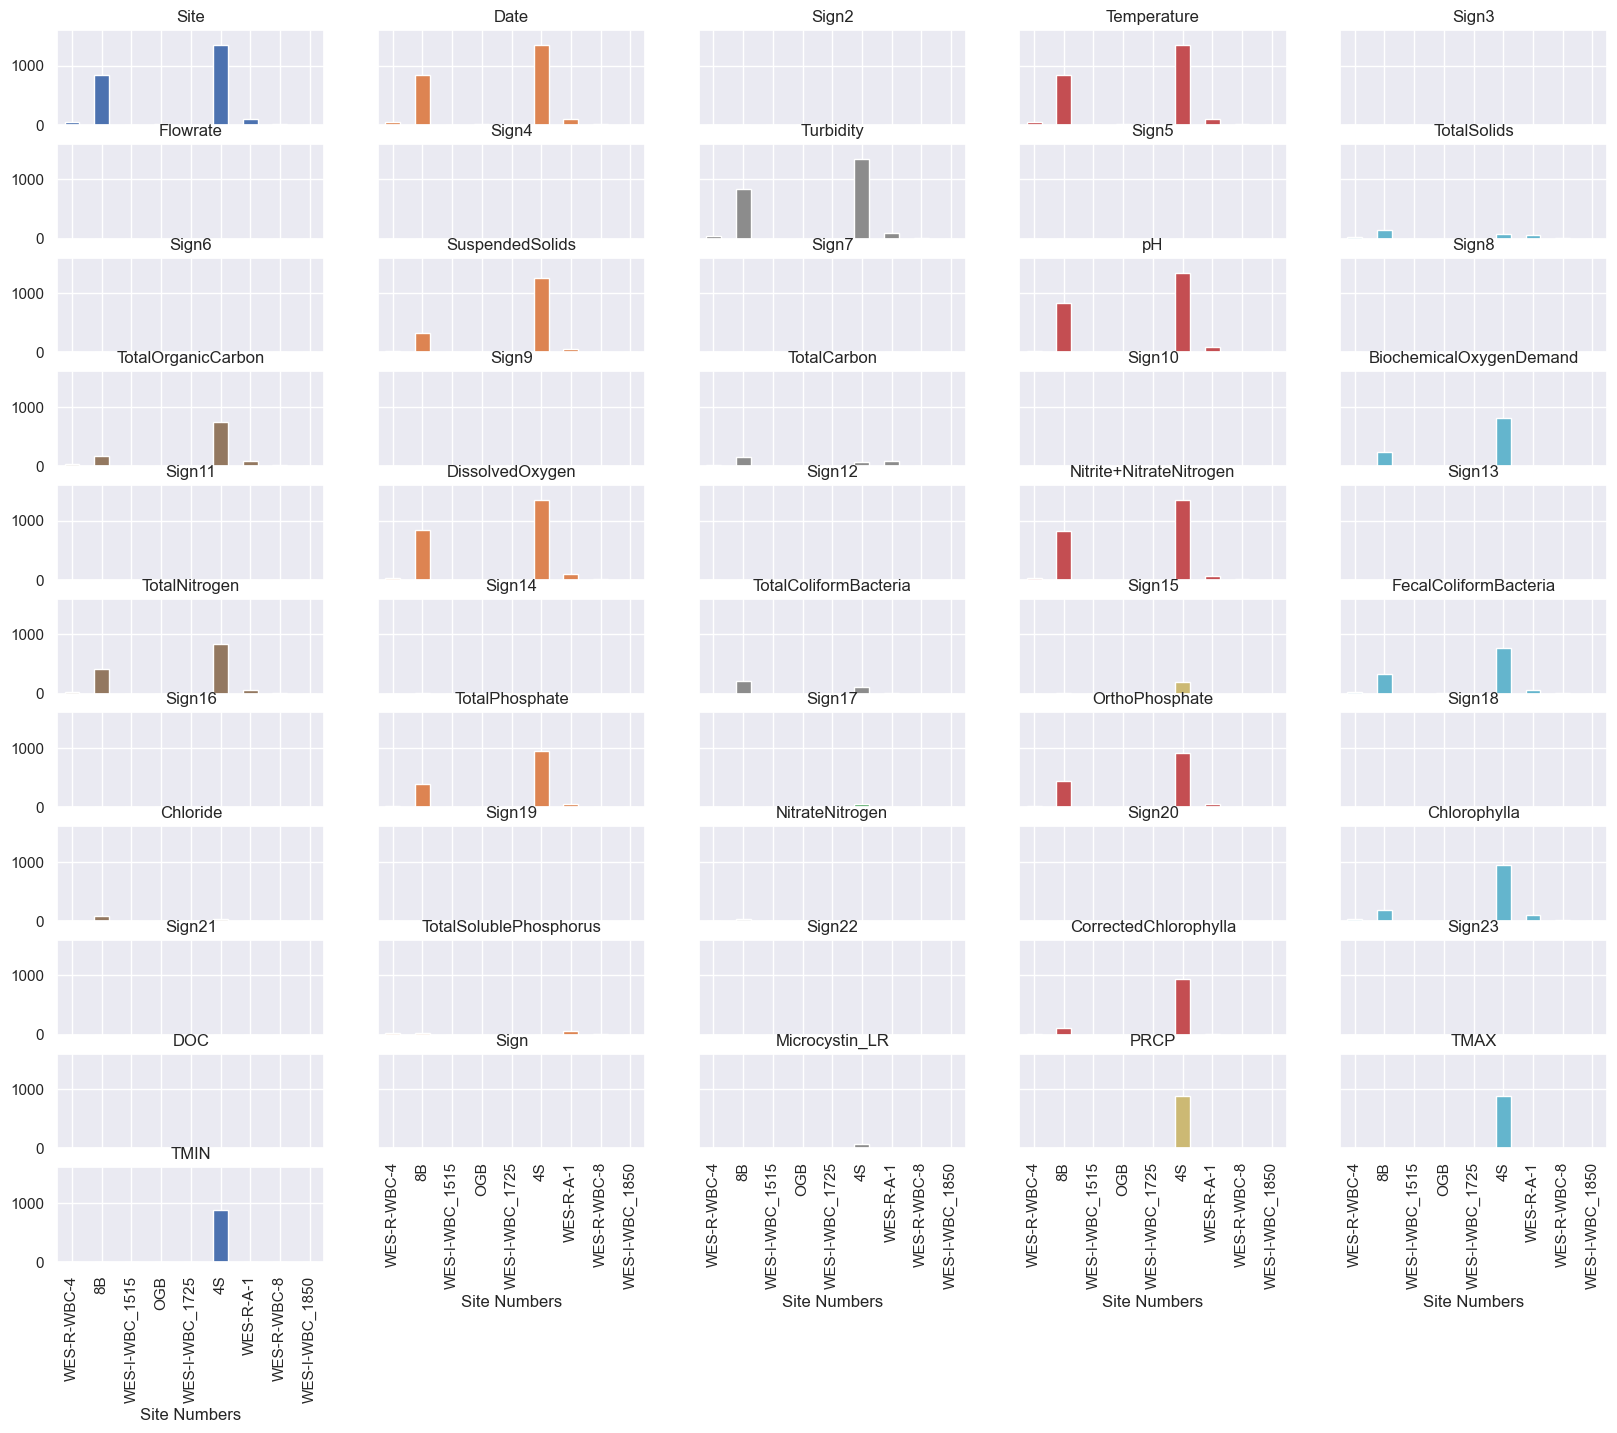

In [40]:
name_id=0

for df in fig_list:
    loop_df = df
    ax = loop_df.plot(x='Site Numbers',
                kind = 'bar',
                stacked = False,
                subplots = True,
                layout = (11,5),
                figsize= (20,16),
                sharex= True,
                sharey= True,
                ylim = (0, 1600),
                legend= False)
    plt.savefig('subbar'+str(name_id)+'.png')
    name_id +=1
    plt.show()

If you want to take a closer look at these plots, open up the folder where this notebook is operating  and you should find each plot saved as "subbar#.png"

Let's take a look at what those sign values are. They don't make up a large portion of our data, so I want to delte them from our dataframe

In [41]:
print(master['Sign3'].value_counts())
print(master['Sign6'].value_counts())
print(master['Sign17'].value_counts())

e    28
Name: Sign3, dtype: int64
e    84
<     5
Name: Sign6, dtype: int64
<    452
e     22
>      1
Name: Sign17, dtype: int64


They make up a tiny portion of our dataset. I am going to decide to delete the sign columns from the dataframe. I alternatively could have just deleted the measurements with these sign values, but I chose to keep them since I am not worried so much about individual measurements as I am about overall trends.

In [42]:
master = master.drop('Sign', axis=1)

index = 2

while index < 24:
    column_name= str('Sign'+str(index))
    master.drop(str(column_name), axis=1, inplace= True)
    index = index+1

## Feature Elimination ##

We have a lot of sampling sites, but some sites do not have a lot of data. Let's identify a few key sites to use moving forward

In [43]:
count_df.groupby('Site Numbers').sum().sum(axis=1).nlargest(10)

Site Numbers
1     27209
5     26444
4S    20855
9     19099
6     18428
10    18218
4B    15279
7     13532
8S    12054
4M    11298
dtype: int64

In [44]:
largest_list = [1,5,"4S",9,6,10,"4B",7,"8S","4M"]

working_df = pd.DataFrame()

for number in largest_list:
    temp = master[master['Site'] == number]
    working_df = pd.concat([working_df, temp])
    
working_df = working_df.reset_index(drop=True)

In [45]:
working_df.isna().sum()

Site                           0
Date                           0
Temperature                    0
Flowrate                    4915
Turbidity                   1254
TotalSolids                10253
SuspendedSolids             4081
pH                           191
TotalOrganicCarbon          7525
TotalCarbon                10369
BiochemicalOxygenDemand     4027
DissolvedOxygen               75
Nitrite+NitrateNitrogen     2527
TotalNitrogen               5840
TotalColiformBacteria      10700
FecalColiformBacteria       6291
TotalPhosphate              5578
OrthoPhosphate              5383
Chloride                   10183
NitrateNitrogen            11290
Chlorophylla                7110
TotalSolublePhosphorus     12535
CorrectedChlorophylla       7676
DOC                        12685
Microcystin_LR             12591
PRCP                        7106
TMAX                        7106
TMIN                        7106
dtype: int64

We still have a lot of NaN values. Let's drop all columns that don't have at least 65% data.

In [46]:
feature_elimination = working_df.copy()

feature_elimination = feature_elimination.dropna(thresh = len(feature_elimination.index)*.65, axis = 1)

feature_elimination.isna().sum()

Site                          0
Date                          0
Temperature                   0
Turbidity                  1254
SuspendedSolids            4081
pH                          191
BiochemicalOxygenDemand    4027
DissolvedOxygen              75
Nitrite+NitrateNitrogen    2527
dtype: int64

Now let's create a dataframe with no NaN values to use for our Machine Learning Models

In [47]:
working_df = feature_elimination.dropna()
working_df = working_df.reset_index(drop=True)

Let's make sure our dataset contains all the right datatypes!

In [48]:
working_df.dtypes

Site                               object
Date                       datetime64[ns]
Temperature                       float64
Turbidity                         float64
SuspendedSolids                   float64
pH                                float64
BiochemicalOxygenDemand            object
DissolvedOxygen                   float64
Nitrite+NitrateNitrogen            object
dtype: object

Hmmmm... I expect all my water quality parameters to be float datatypes. Let's see if we can get an idea of what's going on.

In [49]:
working_df.head()

,Site,Date,Temperature,Turbidity,SuspendedSolids,pH,BiochemicalOxygenDemand,DissolvedOxygen,Nitrite+NitrateNitrogen
0,1,1975-08-12,25.5,31.0,62.0,8.15,6.1,5.62,<0.01
1,1,1975-09-11,26.0,28.0,65.0,8.50,11.8,11.10,<0.01
2,1,1975-09-25,17.5,29.0,75.0,8.60,13.4,13.52,<0.01
3,1,1975-10-09,17.5,37.0,102.0,7.78,19.6,10.15,<0.01
4,1,1975-10-23,17.5,30.0,86.0,8.38,19.9,9.25,<0.01


It looks like the columns include inequality symbols. We will need to get rid of those in order to do machine learning and imputation later.

In [50]:
working_df['BiochemicalOxygenDemand'] = working_df['BiochemicalOxygenDemand'].astype(str)
working_df['BiochemicalOxygenDemand'] = working_df['BiochemicalOxygenDemand'].str.replace('<','',regex=True)
working_df['BiochemicalOxygenDemand'] = working_df['BiochemicalOxygenDemand'].str.replace('>','',regex=True)
working_df['BiochemicalOxygenDemand'] = working_df['BiochemicalOxygenDemand'].astype(float)

working_df['Nitrite+NitrateNitrogen'] = working_df['Nitrite+NitrateNitrogen'].astype(str)
working_df['Nitrite+NitrateNitrogen'] = working_df['Nitrite+NitrateNitrogen'].str.replace('<','',regex=True)
working_df['Nitrite+NitrateNitrogen'] = working_df['Nitrite+NitrateNitrogen'].str.replace('>','',regex=True)
working_df['Nitrite+NitrateNitrogen'] = working_df['Nitrite+NitrateNitrogen'].astype(float)

In [51]:
working_df.dtypes

Site                               object
Date                       datetime64[ns]
Temperature                       float64
Turbidity                         float64
SuspendedSolids                   float64
pH                                float64
BiochemicalOxygenDemand           float64
DissolvedOxygen                   float64
Nitrite+NitrateNitrogen           float64
dtype: object

Now that we have the datatypes all situated. Let's see how many entries we have for each site. This will inform what site pairs we choose to examine in the next section. We want to make sure we choose well balanced pairs so we don't have to do any oversampling or undersampling methods.

In [52]:
working_df['Site'].value_counts()

9     903
1     875
6     867
5     864
10    861
7     807
4S    735
8S    360
4B     73
4M     71
Name: Site, dtype: int64

## Unsupervised ML Modeling ##
*Now that we have a dataframe with no NaN values, what information can we learn? let's see if two sites are distinctly different*

Take your pick of combinations!

In [53]:
#two_sites= [1,"4S"] #Before/After of Saylorville Reservoir
#two_sites = ["4S",5] #Before/AFter Saylorville Dam
#two_sites = [5,6] #Before/After of DSM Metro
#two_sites= [6,7] #DSM River AfterMetro/BeforeReservoir
#two_sites= [7,9] #Before/AFter Red Rock Reservoir and Dam
two_sites= [1,9] #Before/AFter DSM Metro+Saylorville and Red Rock Reservoir and Dam

unsupervised_df = pd.DataFrame()

for number in two_sites:
    temp = working_df[working_df['Site'] == number]
    unsupervised_df = pd.concat([unsupervised_df, temp])
    
unsupervised_df = unsupervised_df.reset_index(drop=True)

How balanced are the chosen sites in terms of samples?

In [54]:
print(unsupervised_df['Site'].value_counts())

9    903
1    875
Name: Site, dtype: int64


Next, we will want to drop the site and sample date columns. This allows our machine learning model to differentiate between sample sites using only sampled data! Let's also make a target values column, so we know how accurate our kmeans value is

In [55]:
target = unsupervised_df.pop('Site') #Pull sample labels from dataframe to use as true labels
unsupervised_df = unsupervised_df.drop(['Date'], axis = 1)

#Put true labels into a dataframe
target = pd.Series.to_frame(target)
target.columns = ['Class']

#Make target valuable binary so they match model labels
target['Class'] = target['Class'].replace(to_replace= two_sites[0], value= 0)
target['Class'] = target['Class'].replace(to_replace= two_sites[1], value= 1)

Now that we have picked our combination, let's see if a kmeans model will be able to distinguish between these two sites!

### KMeans Unsupervised Learning Model ##

In [56]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, n_init = 'auto')

mat = unsupervised_df.values #Convert our dataframe into a matrix that the model can use

kmeans.fit(mat)

labels= kmeans.labels_

results = pd.DataFrame([unsupervised_df.index,labels]).T

results.columns = ['OldID','Class']

results = results.drop('OldID', axis = 1)
results

,Class
0,0
1,0
2,0
3,0
4,0
...,...
1773,0
1774,0
1775,0
1776,0


In [57]:
from sklearn.metrics import accuracy_score

accuracy_score(target,results)

0.48031496062992124

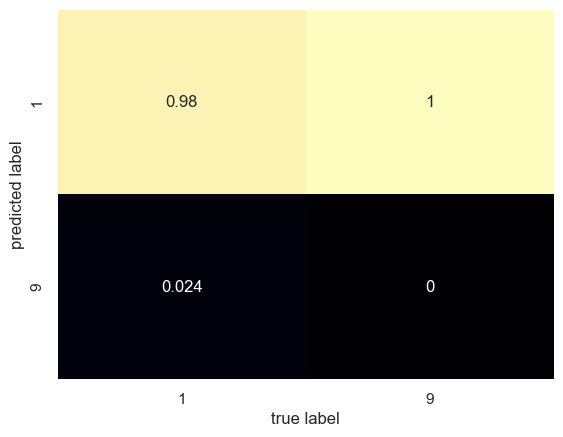

In [58]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(target, results, normalize= 'true')
conf_mat

sns.heatmap(conf_mat.T, square=False, annot=True,cbar=False, cmap='magma', 
            xticklabels=two_sites,
            yticklabels=two_sites)
plt.xlabel('true label')
plt.ylabel('predicted label');

Alright, so kmeans did not perform that well on some of those pairs. Let's see if there's another kind of clustering method that works better?

I will demonstrate two more clustering models below:

If you wish to choose a different clustering method, pick one listed at this link:
https://scikit-learn.org/stable/modules/classes.html#module-sklearn.cluster

### Agglomerative Clustering ###

In [59]:
from sklearn.cluster import AgglomerativeClustering

agcluster = AgglomerativeClustering(n_clusters=2, linkage = 'single')

In [60]:
from sklearn.cluster import AgglomerativeClustering

agcluster = AgglomerativeClustering(n_clusters=2, linkage = 'single') #Instantiate Model

agcluster.fit(mat) #Fit Model to Data

aglabels= agcluster.labels_ #Pull labels from Model

#Prepare results to compare to true labels
agresults = pd.DataFrame([unsupervised_df.index,aglabels]).T
agresults.columns = ['OldID','Class']
agresults = agresults.drop('OldID', axis = 1)

print("Model Accuracy Score")
print(accuracy_score(target,agresults))

Model Accuracy Score
0.4915635545556805


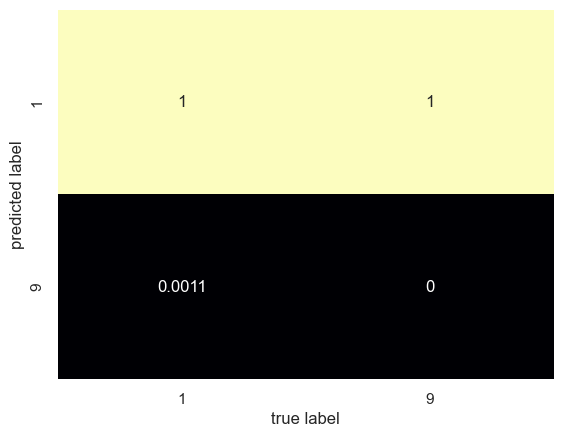

In [61]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(target, agresults, normalize= 'true')
conf_mat

sns.heatmap(conf_mat.T, square=False, annot=True,cbar=False, cmap= 'magma', 
            xticklabels=two_sites,
            yticklabels=two_sites)
plt.xlabel('true label')
plt.ylabel('predicted label');

### Bisecting KMeans ###

In [62]:
from sklearn.cluster import BisectingKMeans

bmeans = BisectingKMeans(n_clusters=2) #Initialize Model

bmeans.fit(mat) #Fit Model to Data

bmeanslabels= bmeans.labels_ #Pull Labels from Model

#Prepare results to directly compare with true labels
bmeansresults = pd.DataFrame([unsupervised_df.index,bmeanslabels]).T
bmeansresults.columns = ['OldID','Class']
bmeansresults = bmeansresults.drop('OldID', axis = 1)

print("Model Accuracy Score:")
print(accuracy_score(target,bmeansresults))

Model Accuracy Score:
0.5196850393700787


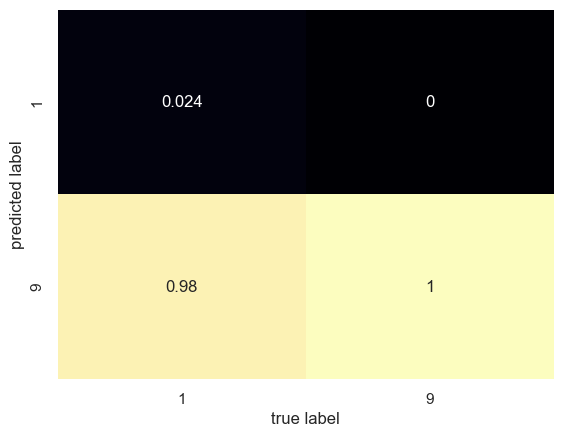

In [63]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(target, bmeansresults, normalize= 'true')
conf_mat

sns.heatmap(conf_mat.T, square=False, annot=True,cbar=False, cmap= 'magma', 
            xticklabels=two_sites,
            yticklabels=two_sites)
plt.xlabel('true label')
plt.ylabel('predicted label');

#### Conclusion ####

It looks like all the clustering methods have trouble clustering our data. They are able to create one cluster, but unable to do more. I think this is good news for the water quality. It is not so adversely affected that these models as constructed are not able to distinguish with water upstream and downstream of our chosen locations.

## Supervised Machine Learning ##

*Dissolved oxygen is an important metric for the sustainability of aquatic life. Let's create a supervised machine learning model to see if we can predict the dissolved oxygen content in the water*.

We know from the first stacked bar plot we created that Sites 1 and 5 have the most data. Let's see which one has a lower NaN percentage and we will choose that one.

In [64]:
site1_df = pd.DataFrame()

site = list([1])

for number in site:
    temp = master[master['Site'] == number]
    site1_df = pd.concat([site1_df, temp])
    
site1_df = site1_df.reset_index(drop=True)

In [65]:
site1_df.isna().sum().sum()/site1_df.size

0.3721518388957171

In [66]:
site5_df = pd.DataFrame()

site=list([5])

for number in site:
    temp = master[master['Site'] == number]
    site5_df = pd.concat([site5_df, temp])
    
site5_df = site5_df.reset_index(drop=True)

In [67]:
site5_df.isna().sum().sum()/site5_df.size

0.37722917852399923

Lookes like Site 1 has a slightly higher density of data. Let's choose that one to use for our machine learning model. We will use imputaton later, let's drop all columns that are not at least 75% data. While we are at it, let's drop the site column as that is no longer needed.

In [68]:
site1_df = site1_df.dropna(thresh = len(site1_df.index)*.75, axis = 1)
site1_df = site1_df.drop(['Site'], axis = 1)

Let's check to see that our columns are the right datatype for the machine learning model, and adjust accordingly.

In [69]:
site1_df.dtypes

Date                       datetime64[ns]
Temperature                       float64
Flowrate                          float64
Turbidity                         float64
pH                                float64
BiochemicalOxygenDemand            object
DissolvedOxygen                   float64
PRCP                              float64
TMAX                              float64
TMIN                              float64
dtype: object

In [70]:
#Change Biochemical Oxygen Demand Column
site1_df['BiochemicalOxygenDemand'] = site1_df['BiochemicalOxygenDemand'].astype(str)
site1_df['BiochemicalOxygenDemand'] = site1_df['BiochemicalOxygenDemand'].str.replace('<','',regex=True)
site1_df['BiochemicalOxygenDemand'] = site1_df['BiochemicalOxygenDemand'].str.replace('>','',regex=True)
site1_df['BiochemicalOxygenDemand'] = site1_df['BiochemicalOxygenDemand'].astype(float)

#Extract Year, Month, and Day from Date Column. ML Model is unable to function with datetime objects
site1_df['Year'] = site1_df['Date'].dt.year
site1_df['Month'] = site1_df['Date'].dt.month
site1_df['Day'] = site1_df['Date'].dt.day

site1_df = site1_df.drop('Date', axis = 1)

Let's save our dataframe later for imputation, and move forward with a dataframe with no NaN values for our machine learning model.

In [71]:
imputation = site1_df.copy()

site1_df = site1_df.dropna()
site1_df = site1_df.reset_index(drop = True)

Let's seperate our dataframe into features and labels for our model. The label is what we are trying to predict, so in this case it will be dissolved oxygen.

In [72]:
import numpy as np

labels = np.array(site1_df['DissolvedOxygen'])

features = site1_df.drop('DissolvedOxygen', axis=1)

#Save feature names for later
feature_list = list(features.columns)

#Convert to an array
features = np.array(features)

Now it's time to split our data into training and testing sets.

In [73]:
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(features,labels,test_size = 0.25)

print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (988, 11)
Training Labels Shape: (988,)
Testing Features Shape: (330, 11)
Testing Labels Shape: (330,)


### Random Forest ###

It is time to use our first machine learning model, random forest.

Learn more here:https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor

Let's instantiate the model below.

In [74]:
from sklearn.ensemble import RandomForestRegressor

#Instantiate model with 10,000 decision trees
rf = RandomForestRegressor(n_estimators = 10000)

#Train the model on training data

rf.fit(train_features,train_labels)

RandomForestRegressor(n_estimators=10000)

Now, let's use the model to predict the dissolved oxygen content and calculate the accuracy of our predictions

In [75]:
#Use the model to predict dissolved oxygen
predictions = rf.predict(test_features)

# Calculate the absolute errors
errors = abs(predictions - test_labels)

#Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)

print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 89.73 %.


How is the model making these predictions? What features are important? Let's find out!

In [76]:
# Get numerical feature importances
importances_list = list(rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances_list)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: TMIN                 Importance: 0.33
Variable: pH                   Importance: 0.25
Variable: Temperature          Importance: 0.13
Variable: Flowrate             Importance: 0.1
Variable: Turbidity            Importance: 0.04
Variable: BiochemicalOxygenDemand Importance: 0.04
Variable: Year                 Importance: 0.04
Variable: TMAX                 Importance: 0.02
Variable: Month                Importance: 0.02
Variable: Day                  Importance: 0.02
Variable: PRCP                 Importance: 0.0


##### Using Grid Search for Hyperparameter Selection ###
Now, let's use GridSearch to select hyperparameters for our model and see if it improves our model!

In [77]:
from sklearn.model_selection import GridSearchCV
param_grid = {'criterion': ['squared_error','poisson'],
             'n_estimators':[100,1000,10000,100000]}

grid = GridSearchCV(RandomForestRegressor(), param_grid, refit= True, verbose =2, scoring = 'neg_mean_absolute_error')

grid.fit(train_features,train_labels)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END ..........criterion=squared_error, n_estimators=100; total time=   0.5s
[CV] END ..........criterion=squared_error, n_estimators=100; total time=   0.5s
[CV] END ..........criterion=squared_error, n_estimators=100; total time=   0.5s
[CV] END ..........criterion=squared_error, n_estimators=100; total time=   0.5s
[CV] END ..........criterion=squared_error, n_estimators=100; total time=   0.5s
[CV] END .........criterion=squared_error, n_estimators=1000; total time=   6.3s
[CV] END .........criterion=squared_error, n_estimators=1000; total time=   6.3s
[CV] END .........criterion=squared_error, n_estimators=1000; total time=   6.3s
[CV] END .........criterion=squared_error, n_estimators=1000; total time=   6.3s
[CV] END .........criterion=squared_error, n_estimators=1000; total time=   6.2s
[CV] END ........criterion=squared_error, n_estimators=10000; total time= 1.1min
[CV] END ........criterion=squared_error, n_estim

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'criterion': ['squared_error', 'poisson'],
                         'n_estimators': [100, 1000, 10000, 100000]},
             scoring='neg_mean_absolute_error', verbose=2)

In [78]:
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

RandomForestRegressor(criterion='poisson', n_estimators=1000)


In [79]:
bestmodel = grid.best_estimator_

Let's rerun our random forest model with the model GridSearch chose!

In [80]:
from sklearn.ensemble import RandomForestRegressor

#Instantiate model with the best hyperparameters
rfb = bestmodel

#Train the model on training data

rfb.fit(train_features,train_labels)

RandomForestRegressor(criterion='poisson', n_estimators=1000)

How accurate is our model now?

In [81]:
#Use the model to predict dissolved oxygen
predictions = rfb.predict(test_features)

# Calculate the absolute errors
errors = abs(predictions - test_labels)

#Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 89.76 %.


Well, it looks like we have roughly the same accuracy.

Let's create a plot to visually compare the predictions against the actual dissolved oxygen values! First we will have to convert our date columns back into a singular datetime object for our actual and predicted values.

**Plot of RF Model vs. Actual Values**

In [82]:
#Actual Values

import datetime

# Dates of actual values
months = features[:, feature_list.index('Month')]
days = features[:, feature_list.index('Day')]
years = features[:, feature_list.index('Year')]

# Create a column of dates
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]

#Convert dates from string to datetime objects
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]

# Dataframe with true values and dates
true_data = pd.DataFrame(data = {'date': dates, 'actual': labels})

In [83]:
# Predicted Values

#Dates of predicted values
months = test_features[:, feature_list.index('Month')]
days = test_features[:, feature_list.index('Day')]
years = test_features[:, feature_list.index('Year')]

# Column of dates
test_dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]

# Convert from string to datetime objects
test_dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in test_dates]

# Dataframe with predictions and dates
predictions_data = pd.DataFrame(data = {'date': test_dates, 'prediction': predictions})

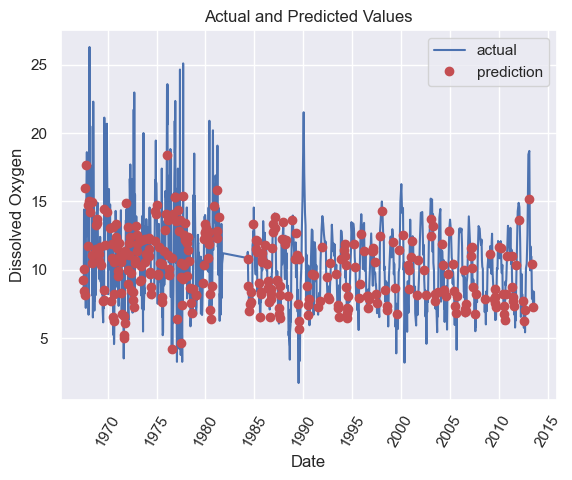

In [84]:
# Plot the actual values
plt.plot(true_data['date'], true_data['actual'], 'b-', label = 'actual')
# Plot the predicted values
plt.plot(predictions_data['date'], predictions_data['prediction'], 'ro', label = 'prediction')
plt.xticks(rotation = '60'); 
plt.legend()
# Graph labels
plt.xlabel('Date'); plt.ylabel('Dissolved Oxygen'); plt.title('Actual and Predicted Values');

plt.savefig('RFvsActualPlot.png')

Let's see if we can get some improvement by running a different regression model. I am going to use the GradientBoostingRegressor, which is very similar to the XGBoost model we learned in class.

### Gradient Boosting Regressor ###

Learn more about this model here: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor

Let's instantiate the model below.

In [85]:
from sklearn.ensemble import GradientBoostingRegressor

#Instantiate model with 10,000 decision trees
boosted = GradientBoostingRegressor(n_estimators = 10000, learning_rate = 1)

#Train the model on training data

boosted.fit(train_features,train_labels)

GradientBoostingRegressor(learning_rate=1, n_estimators=10000)

How accurate is this model?

In [86]:
#Use the model to predict dissolved oxygen
boostpredictions = boosted.predict(test_features)

# Calculate the absolute errors
boosterrors = abs(boostpredictions - test_labels)

#Calculate mean absolute percentage error (MAPE)
boostmape = 100 * (errors / test_labels)

# Calculate and display accuracy
boostaccuracy = 100 - np.mean(boostmape)
print('Accuracy:', round(boostaccuracy, 2), '%.')

Accuracy: 89.76 %.


This model also seems to hover around the 89-90% mark. Let's do a GridSearch to tune our hyperparameters to see if we can get more accuracy.

#### Using GridSearchCV to select best Gradient Boosting Regressor ####

In [87]:
param_grid = {'loss': ['squared_error','absolute_error','huber'],
             'n_estimators':[100,1000,10000],
             'learning_rate': [0.1,1],
             'max_features': [1.0,'sqrt','log2']}

grid = GridSearchCV(GradientBoostingRegressor(), param_grid, refit= True, verbose =2, scoring = 'neg_mean_absolute_error')

grid.fit(train_features,train_labels)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] END learning_rate=0.1, loss=squared_error, max_features=1.0, n_estimators=100; total time=   0.1s
[CV] END learning_rate=0.1, loss=squared_error, max_features=1.0, n_estimators=100; total time=   0.1s
[CV] END learning_rate=0.1, loss=squared_error, max_features=1.0, n_estimators=100; total time=   0.1s
[CV] END learning_rate=0.1, loss=squared_error, max_features=1.0, n_estimators=100; total time=   0.1s
[CV] END learning_rate=0.1, loss=squared_error, max_features=1.0, n_estimators=100; total time=   0.1s
[CV] END learning_rate=0.1, loss=squared_error, max_features=1.0, n_estimators=1000; total time=   1.7s
[CV] END learning_rate=0.1, loss=squared_error, max_features=1.0, n_estimators=1000; total time=   1.7s
[CV] END learning_rate=0.1, loss=squared_error, max_features=1.0, n_estimators=1000; total time=   1.7s
[CV] END learning_rate=0.1, loss=squared_error, max_features=1.0, n_estimators=1000; total time=   1.7s
[CV] EN

[CV] END learning_rate=0.1, loss=absolute_error, max_features=log2, n_estimators=100; total time=   0.1s
[CV] END learning_rate=0.1, loss=absolute_error, max_features=log2, n_estimators=100; total time=   0.1s
[CV] END learning_rate=0.1, loss=absolute_error, max_features=log2, n_estimators=1000; total time=   1.9s
[CV] END learning_rate=0.1, loss=absolute_error, max_features=log2, n_estimators=1000; total time=   1.8s
[CV] END learning_rate=0.1, loss=absolute_error, max_features=log2, n_estimators=1000; total time=   1.8s
[CV] END learning_rate=0.1, loss=absolute_error, max_features=log2, n_estimators=1000; total time=   1.9s
[CV] END learning_rate=0.1, loss=absolute_error, max_features=log2, n_estimators=1000; total time=   1.8s
[CV] END learning_rate=0.1, loss=absolute_error, max_features=log2, n_estimators=10000; total time=  17.9s
[CV] END learning_rate=0.1, loss=absolute_error, max_features=log2, n_estimators=10000; total time=  18.3s
[CV] END learning_rate=0.1, loss=absolute_erro

[CV] END learning_rate=1, loss=squared_error, max_features=sqrt, n_estimators=10000; total time=   4.0s
[CV] END learning_rate=1, loss=squared_error, max_features=sqrt, n_estimators=10000; total time=   3.8s
[CV] END learning_rate=1, loss=squared_error, max_features=sqrt, n_estimators=10000; total time=   4.1s
[CV] END learning_rate=1, loss=squared_error, max_features=sqrt, n_estimators=10000; total time=   4.0s
[CV] END learning_rate=1, loss=squared_error, max_features=log2, n_estimators=100; total time=   0.0s
[CV] END learning_rate=1, loss=squared_error, max_features=log2, n_estimators=100; total time=   0.0s
[CV] END learning_rate=1, loss=squared_error, max_features=log2, n_estimators=100; total time=   0.0s
[CV] END learning_rate=1, loss=squared_error, max_features=log2, n_estimators=100; total time=   0.0s
[CV] END learning_rate=1, loss=squared_error, max_features=log2, n_estimators=100; total time=   0.0s
[CV] END learning_rate=1, loss=squared_error, max_features=log2, n_estimat

[CV] END learning_rate=1, loss=huber, max_features=sqrt, n_estimators=100; total time=   0.2s
[CV] END learning_rate=1, loss=huber, max_features=sqrt, n_estimators=100; total time=   0.2s
[CV] END learning_rate=1, loss=huber, max_features=sqrt, n_estimators=100; total time=   0.3s
[CV] END learning_rate=1, loss=huber, max_features=sqrt, n_estimators=1000; total time=   3.0s
[CV] END learning_rate=1, loss=huber, max_features=sqrt, n_estimators=1000; total time=   2.5s
[CV] END learning_rate=1, loss=huber, max_features=sqrt, n_estimators=1000; total time=   2.6s
[CV] END learning_rate=1, loss=huber, max_features=sqrt, n_estimators=1000; total time=   2.5s
[CV] END learning_rate=1, loss=huber, max_features=sqrt, n_estimators=1000; total time=   2.5s
[CV] END learning_rate=1, loss=huber, max_features=sqrt, n_estimators=10000; total time=  11.6s
[CV] END learning_rate=1, loss=huber, max_features=sqrt, n_estimators=10000; total time=  11.9s
[CV] END learning_rate=1, loss=huber, max_features=

GridSearchCV(estimator=GradientBoostingRegressor(),
             param_grid={'learning_rate': [0.1, 1],
                         'loss': ['squared_error', 'absolute_error', 'huber'],
                         'max_features': [1.0, 'sqrt', 'log2'],
                         'n_estimators': [100, 1000, 10000]},
             scoring='neg_mean_absolute_error', verbose=2)

In [88]:
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

GradientBoostingRegressor(loss='absolute_error', max_features='log2',
                          n_estimators=10000)


In [89]:
bestboostedmodel = grid.best_estimator_

Let's rerun our random forest model with the model GridSearch chose!

In [90]:
#Instantiate model with 10,000 decision trees
boosted = bestboostedmodel

#Train the model on training data

boosted.fit(train_features,train_labels)

GradientBoostingRegressor(loss='absolute_error', max_features='log2',
                          n_estimators=10000)

In [91]:
#Use the model to predict dissolved oxygen
boostpredictions = boosted.predict(test_features)

# Calculate the absolute errors
boosterrors = abs(boostpredictions - test_labels)

#Calculate mean absolute percentage error (MAPE)
boostmape = 100 * (errors / test_labels)

# Calculate and display accuracy
boostaccuracy = 100 - np.mean(boostmape)
print('Accuracy:', round(boostaccuracy, 2), '%.')

Accuracy: 89.76 %.


Looks like roughly the same accuracy. Let's plot the values to see our predictions of dissolved oxygen vs. the actual measured values.

**Plot of Boosted Model Predictions vs. Actual Values**

In [92]:
#Actual Values

import datetime

# Dates of actual values
months = features[:, feature_list.index('Month')]
days = features[:, feature_list.index('Day')]
years = features[:, feature_list.index('Year')]

# Create a column of dates
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]

#Convert dates from string to datetime objects
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]

# Dataframe with true values and dates
true_data = pd.DataFrame(data = {'date': dates, 'actual': labels})

In [93]:
# Predicted Values

#Dates of predicted values
months = test_features[:, feature_list.index('Month')]
days = test_features[:, feature_list.index('Day')]
years = test_features[:, feature_list.index('Year')]

# Column of dates
test_dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]

# Convert from string to datetime objects
test_dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in test_dates]

# Dataframe with predictions and dates
predictions_data = pd.DataFrame(data = {'date': test_dates, 'prediction': boostpredictions})

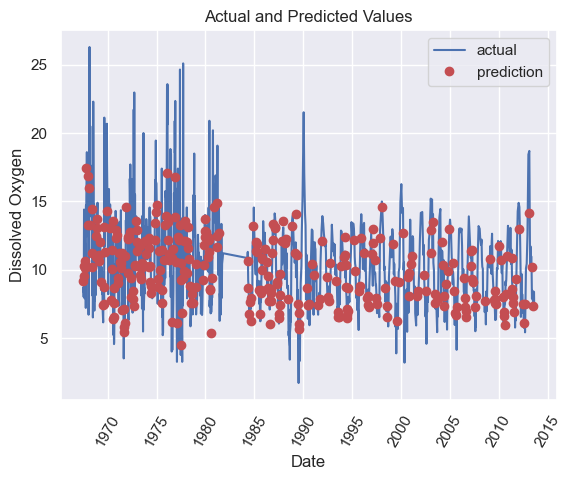

In [94]:
# Plot the actual values
plt.plot(true_data['date'], true_data['actual'], 'b-', label = 'actual')
# Plot the predicted values
plt.plot(predictions_data['date'], predictions_data['prediction'], 'ro', label = 'prediction')
plt.xticks(rotation = '60'); 
plt.legend()
# Graph labels
plt.xlabel('Date'); plt.ylabel('Dissolved Oxygen'); plt.title('Actual and Predicted Values');

plt.savefig('BoostedvsActualPlot.png')

## Imputation ##

Time to seperate the labels and features in our imputation dataset like we did above. First we need to drop all entries that have a NaN value in the Dissolved Oxygen column, because that is our target parameter.

In [95]:
imputation = imputation.dropna(subset=['DissolvedOxygen'])

Now we can seperate the dataset into labels and features

In [96]:
import numpy as np

labels_imp = np.array(imputation['DissolvedOxygen'])

features_imp = imputation.drop('DissolvedOxygen', axis=1)

#Save feature names for later
feature_list = list(features_imp.columns)

#Convert to an array
features_imp = np.array(features_imp)

The code below splits our data into training and testing arrays

In [97]:
from sklearn.model_selection import train_test_split

train_features_imp, test_features_imp, train_labels_imp, test_labels_imp = train_test_split(features_imp,
                                                                                            labels_imp,
                                                                                            test_size = 0.25)

print('Training Features Shape:', train_features_imp.shape)
print('Training Labels Shape:', train_labels_imp.shape)
print('Testing Features Shape:', test_features_imp.shape)
print('Testing Labels Shape:', test_labels_imp.shape)

Training Features Shape: (1127, 11)
Training Labels Shape: (1127,)
Testing Features Shape: (376, 11)
Testing Labels Shape: (376,)


Now, it is time to load an imputer and instantiate it

In [98]:
from sklearn.impute import KNNImputer

knn_imputer = KNNImputer(n_neighbors = 5)

Now, it is time to fit the imputer to the training data, then use it to transform it. After that the imputer will transform the testing data.

We don't want to use the fit the imputer using test data because that would cause data leakage.

In [99]:
train_features_imp[:] = knn_imputer.fit_transform(train_features_imp)
test_features_imp[:] = knn_imputer.transform(test_features_imp)

Now that data has been imputed, we can continue as we did before. Let's use this data with the random forest model using the same parameters for our best performer to see if we can squeak out a little more performance.

In [100]:
#Instantiate the best boosted model from above. Chose this model because it takes much less time to run
ml = grid.best_estimator_

#Train the model on training data

ml.fit(train_features_imp,train_labels_imp)

GradientBoostingRegressor(loss='absolute_error', max_features='log2',
                          n_estimators=10000)

In [101]:
#Use the model to predict dissolved oxygen
predictions = ml.predict(test_features_imp)

# Calculate the absolute errors
errors = abs(predictions - test_labels_imp)

#Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels_imp)

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 88.74 %.


Looks like our imputed model performs in the same ballpark as our non-imputed model. Let's generate a nice visual to see our predicted values plotted with our measured values.

**Plot of Predicted vs. Actual Values**

In [102]:
#Actual Values

import datetime

# Dates of actual values
months = features_imp[:, feature_list.index('Month')]
days = features_imp[:, feature_list.index('Day')]
years = features_imp[:, feature_list.index('Year')]

# Create a column of dates
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]

#Convert dates from string to datetime objects
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]

# Dataframe with true values and dates
true_data = pd.DataFrame(data = {'date': dates, 'actual': labels_imp})

In [103]:
# Predicted Values

#Dates of predicted values
months = test_features_imp[:, feature_list.index('Month')]
days = test_features_imp[:, feature_list.index('Day')]
years = test_features_imp[:, feature_list.index('Year')]

# Column of dates
test_dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]

# Convert from string to datetime objects
test_dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in test_dates]

# Dataframe with predictions and dates
predictions_data = pd.DataFrame(data = {'date': test_dates, 'prediction': predictions})

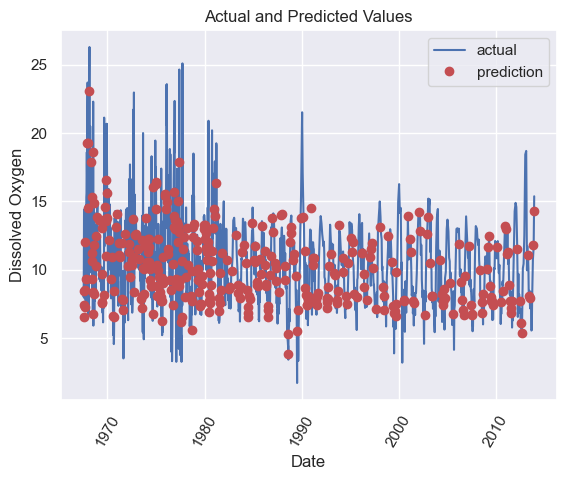

In [104]:
# Plot the actual values
plt.plot(true_data['date'], true_data['actual'], 'b-', label = 'actual')
# Plot the predicted values
plt.plot(predictions_data['date'], predictions_data['prediction'], 'ro', label = 'prediction')
plt.xticks(rotation = '60'); 
plt.legend()
# Graph labels
plt.xlabel('Date'); plt.ylabel('Dissolved Oxygen'); plt.title('Actual and Predicted Values');

plt.savefig('ImputedModelvsActualPlot.png')

## Conclusion ##

Thus concludes the ABE 516 Final Project. The above notebook demonstrated 5 concepts learned in class:
1. Data Wrangling
2. API Calls
3. Unsupervised Machine Learning
4. Supervised Machine Learning
5. Data Imputation

These 5 concepts were used to help answer the following questions about our data.

- How much data do we have?
- Where is it located?
- What kinds of things can we do with all this data?

Before this class, I could have maybe done concept #1 (albeit not as efficiently) but I would not have even known where to start with concepts 2-5. I'm grateful for the skills that I've learned in this class, so that I can apply them to my own research (once I start collecting data)!